## EXCERCISE 1  AUTO COMPLETION AND AUTO CORRECTION 

# GRAMMER CORRECTION

In [10]:
pip install happytransformer


  Using cached happytransformer-3.0.0-py3-none-any.whl (24 kB)
  Using cached accelerate-0.29.2-py3-none-any.whl (297 kB)
  Using cached wandb-0.16.6-py3-none-any.whl (2.2 MB)
  Using cached tokenizers-0.15.2-cp38-none-win_amd64.whl (2.2 MB)
  Using cached datasets-2.18.0-py3-none-any.whl (510 kB)
  Using cached transformers-4.39.3-py3-none-any.whl (8.8 MB)
  Using cached huggingface_hub-0.22.2-py3-none-any.whl (388 kB)
  Using cached aiohttp-3.9.3-cp38-cp38-win_amd64.whl (367 kB)
  Using cached multiprocess-0.70.16-py38-none-any.whl (132 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl (207 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)


https://huggingface.co/vennify/t5-base-grammar-correction?text=grammar%3A+This+sentences+has+has+bads+grammar

In [13]:
from happytransformer import HappyTextToText, TTSettings

happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction")

args = TTSettings(num_beams=5, min_length=1)

# Add the prefix "grammar: " before each input 
result = happy_tt.generate_text("grammar: This sentences has has a bads grammnnnar.", args=args)

print(result.text) # This sentence has bad grammar.

04/09/2024 22:22:36 - INFO - happytransformer.happy_transformer -   Using device: cpu
04/09/2024 22:22:37 - INFO - happytransformer.happy_transformer -   Moving model to cpu
04/09/2024 22:22:37 - INFO - happytransformer.happy_transformer -   Initializing a pipeline


This sentence has a bad grammnnnar.


In [60]:
import nltk
import math
import random
import collections
import numpy as np
import pandas as pd

In [61]:
# Load Data

with open("Dataset/en_US.twitter.txt", "r", encoding="utf8") as f:
    data = f.read()
    
print("No of letters :", len(data))

No of letters : 3335477


In [62]:
# Pre Processing text data

def pre_processing(data):
    
    # String to Sentences
    sentences = data.split("\n")
    sentences = [text.strip() for text in sentences]
    sentences = [text for text in sentences if len(text) > 0]
    
    # Tokenize sentences into tokens
    tokenized_sentences = [nltk.word_tokenize(text.lower()) for text in sentences]
    
    return tokenized_sentences

pre_processing("Sky is blue.\nLeaves are green\nRoses are red.")

[['sky', 'is', 'blue', '.'],
 ['leaves', 'are', 'green'],
 ['roses', 'are', 'red', '.']]

In [63]:
# train and test sets

tokenized_data = pre_processing(data)

random.seed(69)
random.shuffle(tokenized_data)

train_size = int(len(tokenized_data) * 0.8)
train_data = tokenized_data[0:train_size]
test_data = tokenized_data[train_size:]

In [64]:
# Helper Functions

def count_words(tokenized_data):
    
    data = []
    [data.extend(text_l) for text_l in tokenized_data]
    
    return dict(collections.Counter(data))

def get_closed_vocab(tokenized_data, threshold):
    
    vocab = count_words(tokenized_data)
    closed_vocab = set([word for word in vocab if vocab[word] >= threshold])
    
    return closed_vocab

def replace_oov(tokenized_data, closed_vocab):
    
    replaced_tokenized_data = [[word if word in closed_vocab else "<unk>" for word in sentence] for sentence in tokenized_data]
    return replaced_tokenized_data
    
print(count_words([['sky', 'is', 'blue', '.'], ['leaves', 'are', 'green', '.'], ['roses', 'are', 'red', '.']]))
print(get_closed_vocab([['sky', 'is', 'blue', '.'], ['leaves', 'are', 'green', '.'], ['roses', 'are', 'red', '.']], 2))
print(replace_oov([["dogs", "run"], ["cats", "sleep"]], {"dogs", "sleep"}))

{'sky': 1, 'is': 1, 'blue': 1, '.': 3, 'leaves': 1, 'are': 2, 'green': 1, 'roses': 1, 'red': 1}
{'.', 'are'}
[['dogs', '<unk>'], ['<unk>', 'sleep']]


In [65]:
# Pre Processing tokenized_data

def pre_processing(train_data, test_data, threshold):
    
    vocab = get_closed_vocab(train_data, threshold)
    
    train_data_replaced = replace_oov(train_data, vocab)
    test_data_replaced = replace_oov(test_data, vocab)
    
    return train_data_replaced, test_data_replaced, vocab

In [66]:
# Pre Processing on train and test split

train_data_processed, test_data_processed, vocab = pre_processing(train_data, test_data, threshold=2)

### N-Gram

In [67]:
# Helper Functions 

def get_n_gram(data, n, start_token = "<s>", end_token = "<e>"):
    
    pairs = []
    
    for sentence in data:
        
        sentence = n * [start_token] + sentence + [end_token]
        
        for idx in range(len(sentence)-n+1):
            pairs.append(tuple(sentence[idx: idx+n]))
            
    return dict(collections.Counter(pairs))
        
# print("Uni-gram :", get_n_gram([['i', 'like', 'a', 'cat'], ['this', 'dog', 'is', 'like', 'a', 'cat']], 1))
# print("Bi-gram :", get_n_gram([['i', 'like', 'a', 'cat'], ['this', 'dog', 'is', 'like', 'a', 'cat']], 2))


def estimate_probability(word, previous_n_gram, n_gram, n_plus1_gram, vocabulary_size, k=1.0):
    
    previous_n_gram = tuple(previous_n_gram)
    
    string_tuple = previous_n_gram + (word, )
    
    numerator = n_plus1_gram.get(string_tuple, 0) + k
    denominator = n_gram.get(previous_n_gram, 0) + k * vocabulary_size
    
    probability = numerator / denominator
    
    return probability

def estimate_probabilities(previous_n_gram, n_gram, n_plus1_gram, vocab, k=1.0):
    
    previous_n_gram = tuple(previous_n_gram)
    
    vocab = vocab.union({"<e>", "<unk>"})
    vocab_size = len(vocab)
    
    probabilities = {}
    for word in vocab:
        probabilities[word] = estimate_probability(word, previous_n_gram, n_gram, n_plus1_gram, vocab_size, k=k)
    
    return probabilities

### Count and probability matrices

In [69]:
def get_count_matrix(n_plus1_gram, vocab):
    
    vocab = vocab.union({"<e>", "<unk>"})
    
    n_grams = list(set([val[0:-1] for val in n_plus1_gram.keys()]))
    
    row_index = {n_gram:i for i, n_gram in enumerate(n_grams)}
    col_index = {word: i for i, word in enumerate(vocab)}
    
    count_matrix = np.zeros((len(n_grams), len(vocab)))
    
    for key, value in n_plus1_gram.items():
        
        n_gram = key[0: -1]
        word = key[-1]
        
        if word not in vocab:
            continue
            
        i = row_index[n_gram]
        j = col_index[word]
        count_matrix[i][j] = value
        
    count_matrix = pd.DataFrame(count_matrix, index=n_grams, columns=list(vocab))
    return count_matrix

sentences = [['i', 'like', 'a', 'cat'], ['this', 'dog', 'is', 'like', 'a', 'cat']]
words = set(sentences[0] + sentences[1])
bigram = get_n_gram(sentences, 2)

get_count_matrix(bigram, words)

a  cat   is  this  dog  <unk>    i  like  <e>
(a,)     0.0  2.0  0.0   0.0  0.0    0.0  0.0   0.0  0.0
(dog,)   0.0  0.0  1.0   0.0  0.0    0.0  0.0   0.0  0.0
(this,)  0.0  0.0  0.0   0.0  1.0    0.0  0.0   0.0  0.0
(is,)    0.0  0.0  0.0   0.0  0.0    0.0  0.0   1.0  0.0
(like,)  2.0  0.0  0.0   0.0  0.0    0.0  0.0   0.0  0.0
(i,)     0.0  0.0  0.0   0.0  0.0    0.0  0.0   1.0  0.0
(<s>,)   0.0  0.0  0.0   1.0  0.0    0.0  1.0   0.0  0.0
(cat,)   0.0  0.0  0.0   0.0  0.0    0.0  0.0   0.0  2.0

In [70]:
def get_probability_matrix(n_plus1_gram, vocab, k):
    
    count_matrix = get_count_matrix(n_plus1_gram, vocab)
    count_matrix += k
    
    prob_matrix = count_matrix.div(count_matrix.sum(axis=1), axis=0)
    return prob_matrix

sentences = [['i', 'like', 'a', 'cat'], ['this', 'dog', 'is', 'like', 'a', 'cat']]
words = set(sentences[0] + sentences[1])
bigram = get_n_gram(sentences, 2)

get_probability_matrix(bigram, words, k=1)

a       cat        is      this       dog     <unk>         i  \
(a,)     0.090909  0.272727  0.090909  0.090909  0.090909  0.090909  0.090909   
(dog,)   0.100000  0.100000  0.200000  0.100000  0.100000  0.100000  0.100000   
(this,)  0.100000  0.100000  0.100000  0.100000  0.200000  0.100000  0.100000   
(is,)    0.100000  0.100000  0.100000  0.100000  0.100000  0.100000  0.100000   
(like,)  0.272727  0.090909  0.090909  0.090909  0.090909  0.090909  0.090909   
(i,)     0.100000  0.100000  0.100000  0.100000  0.100000  0.100000  0.100000   
(<s>,)   0.090909  0.090909  0.090909  0.181818  0.090909  0.090909  0.181818   
(cat,)   0.090909  0.090909  0.090909  0.090909  0.090909  0.090909  0.090909   

             like       <e>  
(a,)     0.090909  0.090909  
(dog,)   0.100000  0.100000  
(this,)  0.100000  0.100000  
(is,)    0.200000  0.100000  
(like,)  0.090909  0.090909  
(i,)     0.200000  0.100000  
(<s>,)   0.090909  0.090909  
(cat,)   0.090909  0.272727

### Auto Complete System

In [71]:
def suggest_a_word(previous_tokens, n_gram, n_plus1_gram, vocab, k=1.0, start_with=None):
    
    n = len(list(n_gram.keys())[0]) 
    
    previous_n_gram = previous_tokens[-n:]
    
    probabilities = estimate_probabilities(previous_n_gram, n_gram, n_plus1_gram, vocab, k=k)
    
    suggestion = None
    max_prob = 0
    
    for word, prob in probabilities.items():
        
        if start_with != None:
            if not word.startswith(start_with):
                continue
        
        if prob > max_prob:
            suggestion = word            
            max_prob = prob

    return suggestion, max_prob

# sentences = [['i', 'like', 'a', 'cat'], ['this', 'dog', 'is', 'like', 'a', 'cat']]
# unique_words = set(sentences[0] + sentences[1])

# unigram_counts = get_n_gram(sentences, 1)
# bigram_counts = get_n_gram(sentences, 2)

# previous_tokens = ["i", "like"]

# suggest_a_word(previous_tokens, unigram_counts, bigram_counts, unique_words, k=1.0)
# suggest_a_word(previous_tokens, unigram_counts, bigram_counts, unique_words, k=1.0, start_with="c")

In [72]:
# Play ground 

previous_tokens = input("Enter Text : ").lower()
previous_tokens = nltk.word_tokenize(previous_tokens)

unigram = get_n_gram(train_data_processed, 1)
bigram = get_n_gram(train_data_processed, 2)

suggest_a_word(previous_tokens, unigram, bigram, vocab, k=1.0)

Enter Text : i love


('you', 0.014914558299619587)

In [73]:
def choose_a_word(sentence, n_gram, n_plus1_gram, vocab, k=1.0, options=None):
    
    previous_tokens = sentence.lower()
    previous_tokens = nltk.word_tokenize(previous_tokens)
    
    n = len(list(n_gram.keys())[0]) 
    
    previous_n_gram = previous_tokens[-n:]
    
    probabilities = estimate_probabilities(previous_n_gram, n_gram, n_plus1_gram, vocab, k=k)
    
    output = {word: probabilities.get(word, -1) for word in options}
    return output

In [74]:
bigram = get_n_gram(train_data_processed, 2)
trigram = get_n_gram(train_data_processed, 3)


questions = """Mr Patrick is our new (principle/principal).
The company (excepted/accepted) all the terms.
Please don’t keep your dog on the (lose/loose).
The (later/latter) is my best friend.
I need some (stationary/stationery) products for my craftwork.
The actor (excepted/accepted) the Oscar.
I will call you (later/latter) in the evening.
Covid (affects/effects) the lungs.
The (council/counsel) of the ministers were sworn in yesterday.
Robert (too/to) wants to accompany us to the park.
Mia will (council/counsel) me about choosing fashion as my career.
The (bear/bare) at the zoo was very playful.
The sheep have a lot of (fur/far) that keeps them warm.
The hot spring is at the (furthest/ farthest) corner of the street.
Can you (advice/advise) me on how to study for exams?
The team will (loose/lose) the match if they don’t play well.
Can you go (to/too) the market for me?
The teachers asked the students to keep (quite/quiet).
The (heap/hip) of garbage should be cleaned immediately.
This is (there/their) house. """

questions = questions.split("\n")
for question in questions:
    
    question = question.replace(")", "(")
    question = question.split("(")
    
    print(choose_a_word(question[0], bigram, trigram, vocab, k=1.0, options = question[1].split("/")))

{'principle': 6.718172657037286e-05, 'principal': 6.718172657037286e-05}
{'excepted': -1, 'accepted': 6.738544474393532e-05}
{'lose': 6.419309282321222e-05, 'loose': 6.419309282321222e-05}
{'later': 6.739906989283548e-05, 'latter': 6.739906989283548e-05}
{'stationary': -1, 'stationery': -1}
{'excepted': -1, 'accepted': 6.739906989283548e-05}
{'later': 6.734006734006734e-05, 'latter': 6.734006734006734e-05}
{'affects': 6.739906989283548e-05, 'effects': 6.739906989283548e-05}
{'council': 6.739906989283548e-05, 'counsel': 6.739906989283548e-05}
{'too': 6.739906989283548e-05, 'to': 6.739906989283548e-05}
{'council': 6.739906989283548e-05, 'counsel': 6.739906989283548e-05}
{'bear': 6.739906989283548e-05, 'bare': 6.739906989283548e-05}
{'fur': -1, 'far': 6.691648822269808e-05}
{'furthest': -1, ' farthest': -1}
{'advice': 6.697923643670462e-05, 'advise': 6.697923643670462e-05}
{'loose': 6.739452756436177e-05, 'lose': 6.739452756436177e-05}
{'to': 0.0006722237160527024, 'too': 0.00013444474321

### Perplexity Score

In [75]:
def calculate_perplexity(sentence, n_gram, n_plus1_gram, vocab, k=1.0):
    
    n = len(list(n_gram.keys())[0]) 
    
    sentence = ["<s>"] * n + sentence + ["<e>"]
    sentence = tuple(sentence)
    
    N = len(sentence)
    
    product_pi = 1.0
    for i in range(n, N):

        list_t = sentence[i-n:i]    
        
        word = sentence[i]
        probability = estimate_probability(word, list_t, n_gram, n_plus1_gram, len(vocab), k=1)
        
        product_pi *= 1 / probability

    perplexity = product_pi**(1/float(N))
    
    return perplexity


bigram = get_n_gram(train_data_processed, 2)
trigram = get_n_gram(train_data_processed, 3)

calculate_perplexity(test_data_processed[69], bigram, trigram, vocab, k=1.0)

2247.9099690172125

# AUTO CORRECT

### Import library

In [76]:
import re
import string
import numpy as np
import pandas as pd
from collections import Counter

In [79]:
# Helper Functions

def process_data(file_name):
    with open(file_name, "r") as f:
        data = f.read()
        
    data = data.lower()
    words = re.findall("\w+", data)
    
    return words

def get_count(word_l):
    return Counter(word_l)

def get_probs(word_count_dict):
    probs = {}
    
    m = sum(word_count_dict.values())
    for key in word_count_dict:
        probs[key] = word_count_dict[key]/m
    
    return probs

In [80]:
word_l = process_data("Dataset/shakespeare.txt")

vocab = set(word_l)
word_count_dict = get_count(word_l)
word_probs = get_probs(word_count_dict)

print("Vocab size :", len(vocab))
print("Word Count for the word 'muse' :", word_count_dict.get("muse", 0))
print(f"P('muse') :", word_probs["muse"])

Vocab size : 6116
Word Count for the word 'muse' : 18
P('muse') : 0.000335733204013877


In [81]:
# Helper Functions

def delete_letter(word):
    return [word[:idx]+word[idx+1:] for idx in range(len(word))]

def switch_letter(word):
    word_l = list(word)
    
    req_l = []
    for idx in range(len(word)-1):
        word_l[idx], word_l[idx+1] = word_l[idx+1], word_l[idx]
        req_l.append("".join(word_l))
        word_l[idx], word_l[idx+1] = word_l[idx+1], word_l[idx]
        
    return req_l

def replace_letter(word):
    word_l = list(word)
    
    req_l = []
    for idx in range(len(word)):
        for char in string.ascii_lowercase:
            word_l[idx] = char
            req_l.append("".join(word_l))
            word_l[idx] = word[idx]
            
    req_set = set(req_l)
    req_set.remove(word)
    req_l = sorted(list(req_set))
            
    return req_l

def insert_letter(word):
    req_l = []
    for idx in range(len(word)+1):
        for char in string.ascii_lowercase:
            req_l.append(word[:idx]+ char + word[idx:])
            
    return req_l

In [82]:
print("Delete Letter :", len(delete_letter("at")))
print("Switch Letter :", len(switch_letter("at")))
print("Replace Letter :", len(replace_letter("at")))
print("Insert Letter :", len(insert_letter("at")))

Delete Letter : 2
Switch Letter : 1
Replace Letter : 50
Insert Letter : 78


### Combining the edits

In [83]:
def edit_one_letter(word):
    edit_one_set = set()
    
    edit_one_set.update(delete_letter(word))
    edit_one_set.update(switch_letter(word))
    edit_one_set.update(replace_letter(word))
    edit_one_set.update(insert_letter(word))
    
    return edit_one_set


def edit_two_letter(word):
    edit_two_set = set()
    
    edit_one = edit_one_letter(word)
    for w in edit_one:
        if w:
            edit_two_set.update(edit_one_letter(w))
            
    return edit_two_set

In [84]:
print("Edit one Letter :", len(edit_one_letter("at")))
print("Edit Two Letter :", len(edit_two_letter("at")))

Edit one Letter : 129
Edit Two Letter : 7154


### Spelling Suggestions


In [85]:
def get_corrections(word, probs, vocab, n=5):
    
    if (not word) or (word in vocab):
        return [word]
    
    suggestions = list(edit_one_letter(word).intersection(vocab) or edit_two_letter(word).intersection(vocab))
    best = sorted([[s, probs[s]] for s in suggestions], key = lambda x : x[1], reverse=True)
    n_best = [word for word, prob in best[:n]]
    
    return n_best

In [86]:
get_corrections("battl", word_probs, vocab)

['battle', 'batt']

### Minimum Edit distance

In [87]:
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    m = len(source)
    n = len(target)
    
    arr = np.zeros((m+1, n+1), dtype=int)
    
    for row in range(1, m+1):
        arr[row][0] = arr[row-1][0] + del_cost
        
    for col in range(1, n+1):
        arr[0][col] = arr[0][col-1] + ins_cost
    
    for row in range(1, m+1):
        for col in range(1, n+1):
            
            r_cost = rep_cost
            
            if source[row-1] == target[col-1]:
                r_cost = 0
            
            arr[row][col] = min([arr[row-1][col] + del_cost, arr[row][col-1] + ins_cost, arr[row-1][col-1] + r_cost])
            
    min_edit = arr[m][n]
    
    return arr, min_edit

In [88]:
arr, dist = min_edit_distance("stay", "play")

print(pd.DataFrame(arr, index=list("#stay"), columns=list("#play")))

   #  p  l  a  y
#  0  1  2  3  4
s  1  2  3  4  5
t  2  3  4  5  6
a  3  4  5  4  5
y  4  5  6  5  4


### Playground

In [89]:
misspelled_string = input("Enter a Word : ")
misspelled_string = misspelled_string.lower()

string_l = get_corrections(misspelled_string, word_probs, vocab, n=10)

print("\nSpelling Suggestions with Minimum Edit Distance\n")

for word in string_l:
    print(word, " : ", min_edit_distance(misspelled_string, word, 1, 1, 1)[1])

Enter a Word : feathery

Spelling Suggestions with Minimum Edit Distance

feathers  :  1
feather  :  1


# EXCERCISE 2 Sentiment Analysis
##### Building an NLP Sentiment Analysis Pipeline In Python
Reference:https://www.linkedin.com/advice/0/how-do-you-design-implement-nlp-pipelines#:~:text=An%20NLP%20pipeline%20is%20a,entity%20recognition%2C%20or%20sentiment%20analysis.

2.https://www.geeksforgeeks.org/natural-language-processing-nlp-pipeline/
####  1.Data Acquisition
####   2.Text Cleaning
Unicode normalisation:Symbols,Emojis,Special Characters
Regex:String pattern based removal of email,Phine number,URL
Spellingm Correction:Web scraped data - Create a corpus or dictionary of misspelled word
####   3.Text Preprocessing
Words to be separated at the minimum level
Tokenization
Lowercasing
Stop words removal
Stemming/Lemmatization
POS tagging - Assign Parts of speech to each word in the text(NER,Sentimental Analysis& Machine translation)
####   4.Feature Engineering
Text vectorization/Representation
Classical approach:
    One hot encoding
    Bag of words
    Bag of n-grams
    TF-TDF
Neural approach or Word Embedding:
    To understand the contextual meaning
        Continous Bag of word
        Skip gram 
    Pre trained word embedding - Use large corpus --Import Gensim or hugging face Word2Vec by Google,GloVe by stanford    
####   5.Building Model

####   6.Evaluation

### Data Acquisition - https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset
https://www.geeksforgeeks.org/python-pandas-dataframe-drop_duplicates/

### Import necessary Libraries

In [1]:
import pandas as pd
train = pd.read_csv(r"C:\Users\Keerthana\Desktop\Model\NLP\Trail\Dataset\archive_1\train.csv",encoding='ISO-8859-1')

In [2]:
train

textID                                               text  \
0      cb774db0d1                I`d have responded, if I were going   
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2      088c60f138                          my boss is bullying me...   
3      9642c003ef                     what interview! leave me alone   
4      358bd9e861   Sons of ****, why couldn`t they put them on t...   
...           ...                                                ...   
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text sentiment  \
0                    I`d have responded, if I were going   neutral   
1                                               Sooo SAD  negative   
2                                            bullying me  negative   
3                                         leave me alone  negative   
4                                          Sons of ****,  negative   
...                                                  ...       ...   
27476                                             d lost  negative   
27477                                      , don`t force  negative   
27478                          Yay good for both of you.  positive   
27479                         But it was worth it  ****.  positive   
27480  All this flirting going on - The ATG smiles. Y...   neutral   

      Time of Tweet Age of User      Country  Population -2020  \
0           morning        0-20  Afghanistan          38928346   
1              noon       21-30      Albania           2877797   
2             night       31-45      Algeria          43851044   
3           morning       46-60      Andorra             77265   
4              noon       60-70       Angola          32866272   
...             ...         ...          ...               ...   
27476         night       31-45        Ghana          31072940   
27477       morning       46-60       Greece          10423054   
27478          noon       60-70      Grenada            112523   
27479         night      70-100    Guatemala          17915568   
27480       morning        0-20       Guinea          13132795   

       Land Area (Km²)  Density (P/Km²)  
0             652860.0               60  
1              27400.0              105  
2            2381740.0               18  
3                470.0              164  
4            1246700.0               26  
...                ...              ...  
27476         227540.0              137  
27477         128900.0               81  
27478            340.0              331  
27479         107160.0              167  
27480         246000.0               53  

[27481 rows x 10 columns]

In [3]:
train.head(5)

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet Age of User  \
0  I`d have responded, if I were going   neutral       morning        0-20   
1                             Sooo SAD  negative          noon       21-30   
2                          bullying me  negative         night       31-45   
3                       leave me alone  negative       morning       46-60   
4                        Sons of ****,  negative          noon       60-70   

       Country  Population -2020  Land Area (Km²)  Density (P/Km²)  
0  Afghanistan          38928346         652860.0               60  
1      Albania           2877797          27400.0              105  
2      Algeria          43851044        2381740.0               18  
3      Andorra             77265            470.0              164  
4       Angola          32866272        1246700.0               26

In [4]:
train.dropna(inplace=True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27480 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27480 non-null  object 
 4   Time of Tweet     27480 non-null  object 
 5   Age of User       27480 non-null  object 
 6   Country           27480 non-null  object 
 7   Population -2020  27480 non-null  int64  
 8   Land Area (Km²)   27480 non-null  float64
 9   Density (P/Km²)   27480 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.3+ MB


In [6]:
train = train[['text','sentiment']]

In [7]:
test = pd.read_csv(r"C:\Users\Keerthana\Desktop\Model\NLP\Trail\Dataset\archive_1\test.csv",encoding='ISO-8859-1')

In [8]:
test.head()

textID                                               text sentiment  \
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral   
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive   
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative   
3  01082688c6                                        happy bday!  positive   
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive   

  Time of Tweet Age of User      Country  Population -2020  Land Area (Km²)  \
0       morning        0-20  Afghanistan        38928346.0         652860.0   
1          noon       21-30      Albania         2877797.0          27400.0   
2         night       31-45      Algeria        43851044.0        2381740.0   
3       morning       46-60      Andorra           77265.0            470.0   
4          noon       60-70       Angola        32866272.0        1246700.0   

   Density (P/Km²)  
0             60.0  
1            105.0  
2             18.0  
3            164.0  
4             26.0

In [9]:
test.dropna(inplace=True)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3534 entries, 0 to 3533
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 276.1+ KB


In [11]:
test = test[['text','sentiment']]

In [12]:
train

text sentiment
0                    I`d have responded, if I were going   neutral
1          Sooo SAD I will miss you here in San Diego!!!  negative
2                              my boss is bullying me...  negative
3                         what interview! leave me alone  negative
4       Sons of ****, why couldn`t they put them on t...  negative
...                                                  ...       ...
27476   wish we could come see u on Denver  husband l...  negative
27477   I`ve wondered about rake to.  The client has ...  negative
27478   Yay good for both of you. Enjoy the break - y...  positive
27479                         But it was worth it  ****.  positive
27480     All this flirting going on - The ATG smiles...   neutral

[27480 rows x 2 columns]

In [13]:
test

text sentiment
0     Last session of the day  http://twitpic.com/67ezh   neutral
1      Shanghai is also really exciting (precisely -...  positive
2     Recession hit Veronique Branquinho, she has to...  negative
3                                           happy bday!  positive
4                http://twitpic.com/4w75p - I like it!!  positive
...                                                 ...       ...
3529  its at 3 am, im very tired but i can`t sleep  ...  negative
3530  All alone in this old house again.  Thanks for...  positive
3531   I know what you mean. My little dog is sinkin...  negative
3532  _sutra what is your next youtube video gonna b...  positive
3533   http://twitpic.com/4woj2 - omgssh  ang cute n...  positive

[3534 rows x 2 columns]

##### Label Encoding for the o/p columns - +ve , -ve and zero

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y_train = le.fit_transform(train['sentiment'])
y_test = le.transform(test['sentiment'])

In [15]:
y_train

array([1, 0, 0, ..., 2, 2, 1])

In [16]:
y_test

array([1, 2, 0, ..., 0, 2, 2])

In [17]:
import re
def preprocess(data):
    data = data.strip()#Remove leading white spaces
    data = data.lower()#Convert to lower case
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    data = re.sub(url_pattern, "", data)
    username_pattern = re.compile(r"@\w+")
    data = re.sub(username_pattern, "", data)
    hashtag_pattern = re.compile(r"#\w+")
    data = re.sub(hashtag_pattern, "", data)
    data = re.sub(r"([a-zA-Z])\1{2,}", r'\1', data)
    data = re.sub(r'[^a-zA-Z\s]',"",data)#Remove special characters
    #print(type(data))
    return data  
    

In [18]:
train['preprocess_1'] = train['text'].apply(preprocess)
test['preprocess_1'] = test['text'].apply(preprocess)

C:\Users\Keerthana\AppData\Local\Temp\ipykernel_31992\2313223670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['preprocess_1'] = train['text'].apply(preprocess)


In [19]:
train

text sentiment  \
0                    I`d have responded, if I were going   neutral   
1          Sooo SAD I will miss you here in San Diego!!!  negative   
2                              my boss is bullying me...  negative   
3                         what interview! leave me alone  negative   
4       Sons of ****, why couldn`t they put them on t...  negative   
...                                                  ...       ...   
27476   wish we could come see u on Denver  husband l...  negative   
27477   I`ve wondered about rake to.  The client has ...  negative   
27478   Yay good for both of you. Enjoy the break - y...  positive   
27479                         But it was worth it  ****.  positive   
27480     All this flirting going on - The ATG smiles...   neutral   

                                            preprocess_1  
0                      id have responded if i were going  
1               so sad i will miss you here in san diego  
2                                 my boss is bullying me  
3                          what interview leave me alone  
4      sons of  why couldnt they put them on the rele...  
...                                                  ...  
27476  wish we could come see u on denver  husband lo...  
27477  ive wondered about rake to  the client has mad...  
27478  yay good for both of you enjoy the break  you ...  
27479                              but it was worth it    
27480  all this flirting going on  the atg smiles yay...  

[27480 rows x 3 columns]

In [20]:
test

text sentiment  \
0     Last session of the day  http://twitpic.com/67ezh   neutral   
1      Shanghai is also really exciting (precisely -...  positive   
2     Recession hit Veronique Branquinho, she has to...  negative   
3                                           happy bday!  positive   
4                http://twitpic.com/4w75p - I like it!!  positive   
...                                                 ...       ...   
3529  its at 3 am, im very tired but i can`t sleep  ...  negative   
3530  All alone in this old house again.  Thanks for...  positive   
3531   I know what you mean. My little dog is sinkin...  negative   
3532  _sutra what is your next youtube video gonna b...  positive   
3533   http://twitpic.com/4woj2 - omgssh  ang cute n...  positive   

                                           preprocess_1  
0                             last session of the day    
1     shanghai is also really exciting precisely  sk...  
2     recession hit veronique branquinho she has to ...  
3                                            happy bday  
4                                             i like it  
...                                                 ...  
3529  its at  am im very tired but i cant sleep  but...  
3530  all alone in this old house again  thanks for ...  
3531  i know what you mean my little dog is sinking ...  
3532  sutra what is your next youtube video gonna be...  
3533                            omgssh  ang cute ng bby  

[3534 rows x 3 columns]

In [21]:
url_pattern = re.compile(r"https?://\S+|www\.\S+")
data = re.sub(url_pattern, "","www.keerthana.com")

In [22]:
data

''

### Text Cleaning 

In [25]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Keerthana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Keerthana\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [26]:
nltk.stem.WordNetLemmatizer?

In [27]:
def preprocess_2(data:str):
    data = nltk.word_tokenize(data)
    def get_pos(word):
        tag = nltk.pos_tag([word])[0][1].upper()
        tag_dict = {"N":"n","V":"v","R":"r","J":"a"}
        return tag_dict.get(tag,"n")
    lemma = nltk.stem.WordNetLemmatizer()
    data = [lemma.lemmatize(word,pos=get_pos(word))for word in data]
    return data
    


def preprocess_2(data):
    data = nltk.word_tokenize(data)
    def pos(word):
        tag = nltk.pos_tag([word])[0][1].upper()
        tag_dict = {"N":"n","V":"v","R":"r","J":"a"}
        return tag_dict.get(tag,"n")
    lemma = nltk.stem.WordNetLemmatizer()
    data = [lemma.lemmatize(word,pos(word)) for word in data] #if word not in stopwords.words('english')
    return data

In [28]:
train['preprocess_2'] = train['preprocess_1'].apply(preprocess_2)
test['preprocess_2'] = test['preprocess_1'].apply(preprocess_2)

C:\Users\Keerthana\AppData\Local\Temp\ipykernel_31992\2951347327.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['preprocess_2'] = train['preprocess_1'].apply(preprocess_2)


In [29]:
train

text sentiment  \
0                    I`d have responded, if I were going   neutral   
1          Sooo SAD I will miss you here in San Diego!!!  negative   
2                              my boss is bullying me...  negative   
3                         what interview! leave me alone  negative   
4       Sons of ****, why couldn`t they put them on t...  negative   
...                                                  ...       ...   
27476   wish we could come see u on Denver  husband l...  negative   
27477   I`ve wondered about rake to.  The client has ...  negative   
27478   Yay good for both of you. Enjoy the break - y...  positive   
27479                         But it was worth it  ****.  positive   
27480     All this flirting going on - The ATG smiles...   neutral   

                                            preprocess_1  \
0                      id have responded if i were going   
1               so sad i will miss you here in san diego   
2                                 my boss is bullying me   
3                          what interview leave me alone   
4      sons of  why couldnt they put them on the rele...   
...                                                  ...   
27476  wish we could come see u on denver  husband lo...   
27477  ive wondered about rake to  the client has mad...   
27478  yay good for both of you enjoy the break  you ...   
27479                              but it was worth it     
27480  all this flirting going on  the atg smiles yay...   

                                            preprocess_2  
0              [id, have, responded, if, i, were, going]  
1      [so, sad, i, will, miss, you, here, in, san, d...  
2                            [my, bos, is, bullying, me]  
3                    [what, interview, leave, me, alone]  
4      [son, of, why, couldnt, they, put, them, on, t...  
...                                                  ...  
27476  [wish, we, could, come, see, u, on, denver, hu...  
27477  [ive, wondered, about, rake, to, the, client, ...  
27478  [yay, good, for, both, of, you, enjoy, the, br...  
27479                           [but, it, wa, worth, it]  
27480  [all, this, flirting, going, on, the, atg, smi...  

[27480 rows x 4 columns]

In [30]:
train["documents"] = train["preprocess_2"].apply(lambda x : " ".join(x))
test["documents"] = test["preprocess_2"].apply(lambda x : " ".join(x))

C:\Users\Keerthana\AppData\Local\Temp\ipykernel_31992\4153360212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["documents"] = train["preprocess_2"].apply(lambda x : " ".join(x))


In [31]:
train

text sentiment  \
0                    I`d have responded, if I were going   neutral   
1          Sooo SAD I will miss you here in San Diego!!!  negative   
2                              my boss is bullying me...  negative   
3                         what interview! leave me alone  negative   
4       Sons of ****, why couldn`t they put them on t...  negative   
...                                                  ...       ...   
27476   wish we could come see u on Denver  husband l...  negative   
27477   I`ve wondered about rake to.  The client has ...  negative   
27478   Yay good for both of you. Enjoy the break - y...  positive   
27479                         But it was worth it  ****.  positive   
27480     All this flirting going on - The ATG smiles...   neutral   

                                            preprocess_1  \
0                      id have responded if i were going   
1               so sad i will miss you here in san diego   
2                                 my boss is bullying me   
3                          what interview leave me alone   
4      sons of  why couldnt they put them on the rele...   
...                                                  ...   
27476  wish we could come see u on denver  husband lo...   
27477  ive wondered about rake to  the client has mad...   
27478  yay good for both of you enjoy the break  you ...   
27479                              but it was worth it     
27480  all this flirting going on  the atg smiles yay...   

                                            preprocess_2  \
0              [id, have, responded, if, i, were, going]   
1      [so, sad, i, will, miss, you, here, in, san, d...   
2                            [my, bos, is, bullying, me]   
3                    [what, interview, leave, me, alone]   
4      [son, of, why, couldnt, they, put, them, on, t...   
...                                                  ...   
27476  [wish, we, could, come, see, u, on, denver, hu...   
27477  [ive, wondered, about, rake, to, the, client, ...   
27478  [yay, good, for, both, of, you, enjoy, the, br...   
27479                           [but, it, wa, worth, it]   
27480  [all, this, flirting, going, on, the, atg, smi...   

                                               documents  
0                      id have responded if i were going  
1               so sad i will miss you here in san diego  
2                                  my bos is bullying me  
3                          what interview leave me alone  
4      son of why couldnt they put them on the releas...  
...                                                  ...  
27476  wish we could come see u on denver husband los...  
27477  ive wondered about rake to the client ha made ...  
27478  yay good for both of you enjoy the break you p...  
27479                                 but it wa worth it  
27480   all this flirting going on the atg smile yay hug  

[27480 rows x 5 columns]

### Creating a vocabulary from the unique words in the text - set()

In [32]:
vocab = set()
for words in train['preprocess_2']:
    for word in words:
        vocab.add(word)
print("Vocabulary Size:",len(vocab))

Vocabulary Size: 23462


## Feature engineering

## BOW

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [35]:
x_train = cv.fit_transform(train['documents'])
x_test = cv.transform(test['documents'])

In [36]:
cv

CountVectorizer()

In [37]:
x_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
x_test.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [39]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 100)
model.fit(x_train, y_train)


from sklearn.metrics import classification_report, accuracy_score

predict = model.predict(x_test)
print("Accuracy Score :", accuracy_score(y_test, predict), end='\n\n')
print(classification_report(y_true = y_test, y_pred = predict))

Accuracy Score : 0.6983588002263724

              precision    recall  f1-score   support

           0       0.70      0.64      0.67      1001
           1       0.64      0.73      0.68      1430
           2       0.79      0.71      0.75      1103

    accuracy                           0.70      3534
   macro avg       0.71      0.69      0.70      3534
weighted avg       0.71      0.70      0.70      3534



C:\Users\Keerthana\miniconda3\envs\tensor\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## TF IDF Vectorizer

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
td_idf = TfidfVectorizer()


x_train = td_idf.fit_transform(train['documents']) 
x_test = td_idf.transform(test['documents'])

In [42]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 100)
model.fit(x_train, y_train)


from sklearn.metrics import classification_report, accuracy_score

predict = model.predict(x_test)
print("Accuracy Score :", accuracy_score(y_test, predict), end='\n\n')
print(classification_report(y_true = y_test, y_pred = predict))

Accuracy Score : 0.7085455574419921

              precision    recall  f1-score   support

           0       0.73      0.64      0.68      1001
           1       0.64      0.76      0.69      1430
           2       0.81      0.71      0.76      1103

    accuracy                           0.71      3534
   macro avg       0.73      0.70      0.71      3534
weighted avg       0.72      0.71      0.71      3534



C:\Users\Keerthana\miniconda3\envs\tensor\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Continous Bag Of Words
import scipy
print(scipy.__version__)
!python -m pip install -U gensim

In [44]:
pip install gensim

     ---------------------------------------- 24.0/24.0 MB 5.4 MB/s eta 0:00:00
     ---------------------------------------- 61.2/61.2 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [45]:
from gensim.models import Word2Vec

C:\Users\Keerthana\miniconda3\envs\tensor\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [46]:
g_model = Word2Vec(sentences = train['preprocess_2'],vector_size=200,window=5, workers=5, epochs=500)

In [47]:
import numpy as np
def in_vocab(word_l):
    for word in word_l:
        if word not in g_model.wv:
            return False
    else:
        return True

train_vec = [g_model.wv[x].sum(axis = 0) if len(x) and in_vocab(x) else np.zeros((200)) for x in train['preprocess_2']]
test_vec  = [g_model.wv[x].sum(axis = 0) if len(x) and in_vocab(x) else np.zeros((200)) for x in test['preprocess_2']]

In [48]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 1000)
model.fit(train_vec, y_train)

from sklearn.metrics import classification_report, accuracy_score

predict = model.predict(test_vec)
print("Accuracy Score :", accuracy_score(y_test, predict), end='\n\n')
print(classification_report(y_true = y_test, y_pred = predict))

Accuracy Score : 0.5082059988681381

              precision    recall  f1-score   support

           0       0.65      0.26      0.37      1001
           1       0.45      0.85      0.59      1430
           2       0.72      0.29      0.41      1103

    accuracy                           0.51      3534
   macro avg       0.61      0.47      0.46      3534
weighted avg       0.59      0.51      0.47      3534



### Skipgram

In [ ]:
from gensim.models import Word2Vec

g_model = Word2Vec(sentences=train['preprocess_2'], vector_size=200, window=5, workers=5, sg=1, epochs=500)


In [ ]:
def in_vocab(word_l):
    for word in word_l:
        if word not in g_model.wv:
            return False
    else:
        return True

train_vec = [g_model.wv[x].sum(axis = 0) if len(x) and in_vocab(x) else np.zeros((200)) for x in train["preprocess_2"]]
test_vec  = [g_model.wv[x].sum(axis = 0) if len(x) and in_vocab(x) else np.zeros((200)) for x in test["preprocess_2"]]


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 1000)
model.fit(train_vec, y_train)

from sklearn.metrics import classification_report, accuracy_score

predict = model.predict(test_vec)
print("Accuracy Score :", accuracy_score(y_test, predict), end='\n\n')
print(classification_report(y_true = y_test, y_pred = predict))

### WORD2VEC using GloVe of twitter

In [49]:
import gensim.downloader as api

model = api.load("glove-twitter-200")

shape_n = 200

def in_vocab(word_l):
    for word in word_l:
        if word not in model:
            return False
    else:
        return True

train_vec = [model[x].sum(axis = 0) if len(x) and in_vocab(x) else np.zeros((shape_n)) for x in train["preprocess_2"]]
test_vec  = [model[x].sum(axis = 0) if len(x) and in_vocab(x) else np.zeros((shape_n)) for x in test["preprocess_2"]]

In [50]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 1000)
model.fit(train_vec, y_train)

from sklearn.metrics import classification_report, accuracy_score

predict = model.predict(test_vec)
print("Accuracy Score :", accuracy_score(y_test, predict), end='\n\n')
print(classification_report(y_true = y_test, y_pred = predict))

Accuracy Score : 0.6431805319750991

              precision    recall  f1-score   support

           0       0.71      0.56      0.63      1001
           1       0.57      0.73      0.64      1430
           2       0.74      0.61      0.67      1103

    accuracy                           0.64      3534
   macro avg       0.67      0.63      0.64      3534
weighted avg       0.66      0.64      0.64      3534



### Classification using TF-IDF

In [51]:
text = """What is not to like about this product.
Not bad.
Not an issue.
Not buggy.
Not happy.
Not user-friendly.
Not good.
Is it any good?
I do not dislike horror movies. 
Disliking horror movies is not uncommon. 
Sometimes I really hate the show. 
I love having to wait two months for the next series to come out! 
The final episode was surprising with a terrible twist at the end.
The film was easy to watch but I would not recommend it to my friends. 
I LOL’d at the end of the cake scene."""

input_text = text.split("\n")
input_text = [" ".join(preprocess_2(string)) for string in input_text]
#list of sentences similat to the dataframe of sentences in the previous x_test

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer()

train_idf = tf_idf.fit_transform(train["documents"])
pred_idf = tf_idf.transform(input_text)

In [53]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 1000)
model.fit(train_idf, y_train)

predict = model.predict(pred_idf)
predict = le.inverse_transform(predict)#transform back to its original form 

In [54]:
for index, text in enumerate(text.split("\n")):
    print(text, " : ", predict[index])

What is not to like about this product.  :  negative
Not bad.  :  negative
Not an issue.  :  negative
Not buggy.  :  neutral
Not happy.  :  positive
Not user-friendly.  :  neutral
Not good.  :  positive
Is it any good?  :  positive
I do not dislike horror movies.   :  negative
Disliking horror movies is not uncommon.   :  negative
Sometimes I really hate the show.   :  negative
I love having to wait two months for the next series to come out!   :  positive
The final episode was surprising with a terrible twist at the end.  :  neutral
The film was easy to watch but I would not recommend it to my friends.   :  neutral
I LOL’d at the end of the cake scene.  :  neutral


# TRAIL 1 KRISH NAIK -  Word Embedding Techniques using Embedding Layer in Keras

In [55]:
import tensorflow as tf

In [58]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import numpy as np


In [59]:
### sentences
sent=[  'the glass of milk',
     'the glass of juice',
     'the cup of tea',
    'I am a good boy',
     'I am a good developer',
     'understand the meaning of words',
     'your videos are good']

In [61]:
### Vocabulary size- large more better represrntaion
voc_size=500

In [62]:
onehot_repr = [one_hot(words, voc_size) for words in sent]
print(onehot_repr)##for every word in the sentence get one hot repr

[[260, 88, 345, 467], [260, 88, 345, 27], [260, 378, 345, 290], [119, 348, 336, 137, 463], [119, 348, 336, 137, 238], [35, 260, 195, 345, 389], [401, 323, 184, 137]]


In [63]:
#prepadding
sent_length = 8
embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)
print(embedded_docs)

[[  0   0   0   0 260  88 345 467]
 [  0   0   0   0 260  88 345  27]
 [  0   0   0   0 260 378 345 290]
 [  0   0   0 119 348 336 137 463]
 [  0   0   0 119 348 336 137 238]
 [  0   0   0  35 260 195 345 389]
 [  0   0   0   0 401 323 184 137]]


In [64]:
dim = 10

##  Word Embedding Represntation

In [65]:
model = Sequential()
model.add(Embedding(voc_size, 10, input_length=sent_length))
model.compile('adam', 'mse')
print(model.predict(embedded_docs))


1/1 [==============================] - 0s 312ms/step
[[[-0.00038818  0.0264838  -0.0218222  -0.03613442 -0.0135303
    0.03346933 -0.0091741   0.02264116 -0.00549722 -0.04325755]
  [-0.00038818  0.0264838  -0.0218222  -0.03613442 -0.0135303
    0.03346933 -0.0091741   0.02264116 -0.00549722 -0.04325755]
  [-0.00038818  0.0264838  -0.0218222  -0.03613442 -0.0135303
    0.03346933 -0.0091741   0.02264116 -0.00549722 -0.04325755]
  [-0.00038818  0.0264838  -0.0218222  -0.03613442 -0.0135303
    0.03346933 -0.0091741   0.02264116 -0.00549722 -0.04325755]
  [ 0.03813979 -0.02189473 -0.03730441  0.04506952  0.04148116
    0.00661234 -0.02205688  0.04097916 -0.00062736  0.01835859]
  [ 0.04406399  0.01906839 -0.03491433  0.0292807   0.04804336
   -0.00872854 -0.03371085 -0.0465048   0.00153401 -0.04121382]
  [ 0.02491916  0.00232536 -0.04812098 -0.01664027  0.04723792
   -0.00875103 -0.04072712 -0.00390731 -0.04503112  0.03713522]
  [ 0.03023826 -0.03162196 -0.0434547  -0.02001034  0.0092754


In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 10)             5000      
                                                                 
Total params: 5,000
Trainable params: 5,000
Non-trainable params: 0
_________________________________________________________________


In [67]:
##'the glass of milk',
embedded_docs[0]

array([  0,   0,   0,   0, 260,  88, 345, 467])

In [68]:
model.predict(embedded_docs[0])

1/1 [==============================] - 0s 64ms/step


array([[-0.00038818,  0.0264838 , -0.0218222 , -0.03613442, -0.0135303 ,
         0.03346933, -0.0091741 ,  0.02264116, -0.00549722, -0.04325755],
       [-0.00038818,  0.0264838 , -0.0218222 , -0.03613442, -0.0135303 ,
         0.03346933, -0.0091741 ,  0.02264116, -0.00549722, -0.04325755],
       [-0.00038818,  0.0264838 , -0.0218222 , -0.03613442, -0.0135303 ,
         0.03346933, -0.0091741 ,  0.02264116, -0.00549722, -0.04325755],
       [-0.00038818,  0.0264838 , -0.0218222 , -0.03613442, -0.0135303 ,
         0.03346933, -0.0091741 ,  0.02264116, -0.00549722, -0.04325755],
       [ 0.03813979, -0.02189473, -0.03730441,  0.04506952,  0.04148116,
         0.00661234, -0.02205688,  0.04097916, -0.00062736,  0.01835859],
       [ 0.04406399,  0.01906839, -0.03491433,  0.0292807 ,  0.04804336,
        -0.00872854, -0.03371085, -0.0465048 ,  0.00153401, -0.04121382],
       [ 0.02491916,  0.00232536, -0.04812098, -0.01664027,  0.04723792,
        -0.00875103, -0.04072712, -0.00390731

In [69]:
print(model.predict(embedded_docs))

1/1 [==============================] - 0s 27ms/step
[[[-0.00038818  0.0264838  -0.0218222  -0.03613442 -0.0135303
    0.03346933 -0.0091741   0.02264116 -0.00549722 -0.04325755]
  [-0.00038818  0.0264838  -0.0218222  -0.03613442 -0.0135303
    0.03346933 -0.0091741   0.02264116 -0.00549722 -0.04325755]
  [-0.00038818  0.0264838  -0.0218222  -0.03613442 -0.0135303
    0.03346933 -0.0091741   0.02264116 -0.00549722 -0.04325755]
  [-0.00038818  0.0264838  -0.0218222  -0.03613442 -0.0135303
    0.03346933 -0.0091741   0.02264116 -0.00549722 -0.04325755]
  [ 0.03813979 -0.02189473 -0.03730441  0.04506952  0.04148116
    0.00661234 -0.02205688  0.04097916 -0.00062736  0.01835859]
  [ 0.04406399  0.01906839 -0.03491433  0.0292807   0.04804336
   -0.00872854 -0.03371085 -0.0465048   0.00153401 -0.04121382]
  [ 0.02491916  0.00232536 -0.04812098 -0.01664027  0.04723792
   -0.00875103 -0.04072712 -0.00390731 -0.04503112  0.03713522]
  [ 0.03023826 -0.03162196 -0.0434547  -0.02001034  0.0092754
 

In [70]:
embedded_docs[0]

array([  0,   0,   0,   0, 260,  88, 345, 467])

In [71]:
print(model.predict(embedded_docs)[0])

1/1 [==============================] - 0s 27ms/step
[[-0.00038818  0.0264838  -0.0218222  -0.03613442 -0.0135303   0.03346933
  -0.0091741   0.02264116 -0.00549722 -0.04325755]
 [-0.00038818  0.0264838  -0.0218222  -0.03613442 -0.0135303   0.03346933
  -0.0091741   0.02264116 -0.00549722 -0.04325755]
 [-0.00038818  0.0264838  -0.0218222  -0.03613442 -0.0135303   0.03346933
  -0.0091741   0.02264116 -0.00549722 -0.04325755]
 [-0.00038818  0.0264838  -0.0218222  -0.03613442 -0.0135303   0.03346933
  -0.0091741   0.02264116 -0.00549722 -0.04325755]
 [ 0.03813979 -0.02189473 -0.03730441  0.04506952  0.04148116  0.00661234
  -0.02205688  0.04097916 -0.00062736  0.01835859]
 [ 0.04406399  0.01906839 -0.03491433  0.0292807   0.04804336 -0.00872854
  -0.03371085 -0.0465048   0.00153401 -0.04121382]
 [ 0.02491916  0.00232536 -0.04812098 -0.01664027  0.04723792 -0.00875103
  -0.04072712 -0.00390731 -0.04503112  0.03713522]
 [ 0.03023826 -0.03162196 -0.0434547  -0.02001034  0.0092754   0.03191068

# TRAIL 2 KRISH NAIK -  Fake News classifier using LSTM

In [73]:
import pandas as pd

In [75]:
df=pd.read_csv(r"C:\Users\Keerthana\Desktop\Model\NLP\Trail\Dataset\Fake\train.csv")

In [76]:
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [77]:
df.shape

(20800, 5)

In [78]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [79]:
###Drop Nan Values
df=df.dropna()

In [80]:
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [81]:
## Get the Independent Features
X=df.drop('label',axis=1)

In [82]:
## Get the Dependent features
y=df['label']

In [83]:
X.shape

(18285, 4)

In [84]:
X

id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiumnews.com   
3                                Jessica Purkiss   
4                                 Howard Portnoy   
...                                          ...   
20795                              Jerome Hudson   
20796                           Benjamin Hoffman   
20797  Michael J. de la Merced and Rachel Abrams   
20798                                Alex Ansary   
20799                              David Swanson   

                                                    text  
0      House Dem Aide: We Didn’t Even See Comey’s Let...  
1      Ever get the feeling your life circles the rou...  
2      Why the Truth Might Get You Fired October 29, ...  
3      Videos 15 Civilians Killed In Single US Airstr...  
4      Print \nAn Iranian woman has been sentenced to...  
...                                                  ...  
20795  Rapper T. I. unloaded on black celebrities who...  
20796  When the Green Bay Packers lost to the Washing...  
20797  The Macy’s of today grew from the union of sev...  
20798  NATO, Russia To Hold Parallel Exercises In Bal...  
20799    David Swanson is an author, activist, journa...  

[18285 rows x 4 columns]

In [85]:
y.shape

(18285,)

In [87]:
type(y)

pandas.core.series.Series

In [88]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [89]:
### Vocabulary size
voc_size=5000

### Onehot Representation

In [90]:
messages=X.copy()

In [91]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [92]:
messages

id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiumnews.com   
3                                Jessica Purkiss   
4                                 Howard Portnoy   
...                                          ...   
20795                              Jerome Hudson   
20796                           Benjamin Hoffman   
20797  Michael J. de la Merced and Rachel Abrams   
20798                                Alex Ansary   
20799                              David Swanson   

                                                    text  
0      House Dem Aide: We Didn’t Even See Comey’s Let...  
1      Ever get the feeling your life circles the rou...  
2      Why the Truth Might Get You Fired October 29, ...  
3      Videos 15 Civilians Killed In Single US Airstr...  
4      Print \nAn Iranian woman has been sentenced to...  
...                                                  ...  
20795  Rapper T. I. unloaded on black celebrities who...  
20796  When the Green Bay Packers lost to the Washing...  
20797  The Macy’s of today grew from the union of sev...  
20798  NATO, Russia To Hold Parallel Exercises In Bal...  
20799    David Swanson is an author, activist, journa...  

[18285 rows x 4 columns]

In [103]:
messages.reset_index(inplace=True)

In [104]:
import nltk
import re
from nltk.corpus import stopwords

In [105]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Keerthana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [106]:
import re
import nltk

In [107]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer ##stemming purpose
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub(r'[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [108]:
corpus

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'beno hamon win french socialist parti presidenti nomin new york time',
 'back channel plan ukrain russia courtesi trump associ new york time',
 'obama organ action partner soro link indivis disrupt trump agenda',
 'bbc comedi sketch real housew isi caus outrag',
 'russian research discov secret nazi militari base treasur hunter arctic photo',
 'us offici see link trump russia',
 'ye paid govern troll social media blog forum websit',
 'major leagu soccer argentin find home success new york time',
 'well fargo chief abruptli step new york time',
 'anonym donor pay million releas everyon arrest dakota access pipelin',
 'fbi close hilla

In [109]:
corpus[1]

'flynn hillari clinton big woman campu breitbart'

In [110]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr

[[2700, 1629, 2809, 2351, 2826, 966, 3327, 2391, 3334, 4590],
 [1142, 2922, 1784, 1845, 3062, 4563, 3599],
 [839, 2097, 605, 2400],
 [2947, 4682, 442, 917, 1521, 1286],
 [3798, 3062, 1064, 4519, 1436, 760, 3062, 1126, 4361, 2580],
 [4606,
  3006,
  2074,
  2271,
  2506,
  4840,
  1954,
  2441,
  682,
  4940,
  1742,
  3895,
  777,
  709,
  3599],
 [1910, 1625, 3285, 3522, 3242, 1766, 2460, 4364, 3396, 4392, 3994],
 [1559, 2791, 3375, 3577, 2360, 4219, 4840, 3413, 3396, 4392, 3994],
 [4305, 2495, 1142, 2342, 2672, 468, 1626, 3434, 4840, 1571],
 [2703, 439, 217, 4006, 3191, 2493, 2875, 1989],
 [1485, 3539, 3076, 2146, 71, 3931, 3623, 3441, 4363, 2357, 3803],
 [917, 199, 2826, 468, 4840, 2360],
 [1998, 4055, 1851, 313, 1851, 3435, 1536, 3301, 4565],
 [1566, 507, 720, 4623, 4617, 10, 4871, 3396, 4392, 3994],
 [1213, 4448, 3299, 720, 870, 3396, 4392, 3994],
 [1061, 3422, 4789, 3398, 3180, 67, 4899, 3931, 4122, 438],
 [2952, 1106, 2922],
 [3522, 2476, 1683, 4169, 4840, 2682, 3401, 3599],
 [4

In [111]:
corpus[1]

'flynn hillari clinton big woman campu breitbart'

In [112]:
onehot_repr[1]

[1142, 2922, 1784, 1845, 3062, 4563, 3599]

### Embedding Representation

In [113]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)
print(embedded_docs)

[[2700 1629 2809 ...    0    0    0]
 [1142 2922 1784 ...    0    0    0]
 [ 839 2097  605 ...    0    0    0]
 ...
 [4370 2158 4131 ...    0    0    0]
 [2243 2360 2502 ...    0    0    0]
 [3078 4350 3718 ...    0    0    0]]


In [114]:
embedded_docs[1]

array([1142, 2922, 1784, 1845, 3062, 4563, 3599,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [115]:
embedded_docs[0]

array([2700, 1629, 2809, 2351, 2826,  966, 3327, 2391, 3334, 4590,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [116]:
## Creating model
embedding_vector_features=40 ##features representation
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [117]:
len(embedded_docs),y.shape

(18285, (18285,))

In [118]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [119]:
X_final.shape,y_final.shape

((18285, 20), (18285,))

In [120]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [121]:
### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
192/192 [==============================] - 12s 11ms/step - loss: 0.3143 - accuracy: 0.8459 - val_loss: 0.2045 - val_accuracy: 0.9185
Epoch 2/10
192/192 [==============================] - 1s 7ms/step - loss: 0.1386 - accuracy: 0.9498 - val_loss: 0.2074 - val_accuracy: 0.9201
Epoch 3/10
192/192 [==============================] - 2s 9ms/step - loss: 0.0958 - accuracy: 0.9648 - val_loss: 0.2237 - val_accuracy: 0.9185
Epoch 4/10
192/192 [==============================] - 2s 8ms/step - loss: 0.0693 - accuracy: 0.9776 - val_loss: 0.2332 - val_accuracy: 0.9198
Epoch 5/10
192/192 [==============================] - 2s 8ms/step - loss: 0.0469 - accuracy: 0.9859 - val_loss: 0.2839 - val_accuracy: 0.9142
Epoch 6/10
192/192 [==============================] - 2s 8ms/step - loss: 0.0367 - accuracy: 0.9895 - val_loss: 0.3883 - val_accuracy: 0.9137
Epoch 7/10
192/192 [==============================] - 2s 8ms/step - loss: 0.0271 - accuracy: 0.9918 - val_loss: 0.3518 - val_accuracy: 0.9163
Epoc

In [122]:
from tensorflow.keras.layers import Dropout
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### Performance Metrics And Accuracy

In [123]:
y_pred=model.predict(X_test)

189/189 [==============================] - 1s 4ms/step


In [124]:
y_pred=np.where(y_pred > 0.6, 1,0) ##AUC ROC Curve

In [125]:
from sklearn.metrics import confusion_matrix

In [126]:
confusion_matrix(y_test,y_pred)

array([[3419,    0],
       [2616,    0]], dtype=int64)

In [127]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.5665285832642917

In [128]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.57      1.00      0.72      3419
           1       0.00      0.00      0.00      2616

    accuracy                           0.57      6035
   macro avg       0.28      0.50      0.36      6035
weighted avg       0.32      0.57      0.41      6035



C:\Users\Keerthana\miniconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Keerthana\miniconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Keerthana\miniconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## EXERCISE 4 - OFFENSIVE LANGUAGE IDENTIFICATION / HATE SPEECH IDENTIFICATION
### Pipeline
* Load Dataset
* Clean the Dataset
* Text Pre-Processing
* Text Vectorization
* Build and Train Model
* Plot Classification Report

### Import Library

In [41]:
# Import Library

import re
import nltk
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

### Load Dataset

In [42]:
# Load Dataset

def load_dataset(file_name):
    
    df = pd.read_csv(file_name)
    
    df = df[["tweet", "class"]]
    df.drop_duplicates(inplace = True)
    df.dropna(inplace = True)
    
    return df

df = load_dataset("Dataset/labeled_data.csv")

print("Train Shape :", df.shape)

df.head()

Train Shape : (24783, 2)


tweet  class
0  !!! RT @mayasolovely: As a woman you shouldn't...      2
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1

### Text - Preprocessing

In [43]:
# Tweet Preprocessing

def pre_processing(tweet: str):
    
    # Remove Leading Blank Spaces
    tweet = tweet.strip()
    
    # Lower Case
    tweet = tweet.lower()
    
    # Remove URLS 
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    tweet = re.sub(url_pattern, "", tweet)
    
    # Remove UserName
    username_pattern = re.compile(r"@\w+")
    tweet = re.sub(username_pattern, "", tweet)
    
    # Remove Hashtags
    hashtag_pattern = re.compile(r"#\w+")
    tweet = re.sub(hashtag_pattern, "", tweet)
    
    # Character normalization // todaaaaay -> today
    tweet = re.sub(r"([a-zA-Z])\1{2,}", r'\1', tweet)
    
    # Remove Special Characters
    tweet = re.sub(r'[^a-zA-Z\s]', "", tweet)
    
    # Word Tokenizer
    tweet = nltk.word_tokenize(tweet)
    
    # Remove Stop Words 
    stop_words = set([re.sub(r'[^a-zA-Z\s]', "", word) for word in nltk.corpus.stopwords.words("english")])
    tweet = [word for word in tweet if word not in stop_words]
    
    # lemmatization
    def get_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"N": "n", "V": "v", "R": "r", "J": "a"}
        return tag_dict.get(tag, "n")
    
    lemma = nltk.stem.WordNetLemmatizer()
    tweet = [lemma.lemmatize(word, pos=get_pos(word)) for word in tweet]
    
    return tweet

df["pre-tweet"] = df["tweet"].apply(pre_processing)

pre_processing("I loveeeee NLP, @rahul_appu, www.rahul_appu.com, #NLP ")

['love', 'nlp']

### Train Test Split

In [44]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df["pre-tweet"].values, df["class"].values, train_size=0.8)

### Vocab

In [45]:
vocab = set()

for words in x_train:
    for word in words:
        vocab.add(word)
        
print("Vocab Size :", len(vocab))

Vocab Size : 14569


### Vectorization

#### Word2Vec

In [46]:
from gensim.models import Word2Vec

g_model = Word2Vec(vector_size=200, window=5, workers=5)
g_model.build_vocab(x_train)
g_model.train(x_train, total_examples=g_model.corpus_count, epochs=500)

(52823922, 76674500)

In [47]:
def in_vocab(word_l):
    for word in word_l:
        if word not in g_model.wv:
            return False
    else:
        return True

train_vec = [g_model.wv[x].sum(axis = 0) if len(x) and in_vocab(x) else np.zeros((200)) for x in x_train]
test_vec  = [g_model.wv[x].sum(axis = 0) if len(x) and in_vocab(x) else np.zeros((200)) for x in x_test]

In [48]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 1000)
model.fit(train_vec, y_train)

from sklearn.metrics import classification_report, accuracy_score

predict = model.predict(test_vec)
print("Accuracy Score :", accuracy_score(y_test, predict), end='\n\n')
print(classification_report(y_true = y_test, y_pred = predict))

Accuracy Score : 0.8055275368166229

              precision    recall  f1-score   support

           0       0.45      0.06      0.11       280
           1       0.81      0.98      0.89      3864
           2       0.79      0.21      0.33       813

    accuracy                           0.81      4957
   macro avg       0.68      0.42      0.44      4957
weighted avg       0.79      0.81      0.75      4957



#### fastText

In [90]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df["tweet"].values, df["class"].values, train_size=0.8)

with open("text.txt", "w") as f: 
    for text in x_train:
        f.write(text + "\n")

In [94]:
import fasttext

f_model = fasttext.train_unsupervised("text.txt", "cbow")

In [95]:
train_vec = [f_model[sent] for sent in x_train]
test_vec  = [f_model[sent] for sent in x_test]

In [96]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 1000)
model.fit(train_vec, y_train)

from sklearn.metrics import classification_report, accuracy_score

predict = model.predict(test_vec)
print("Accuracy Score :", accuracy_score(y_test, predict), end='\n\n')
print(classification_report(y_true = y_test, y_pred = predict))

Accuracy Score : 0.7843453701835787

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       287
           1       0.78      1.00      0.88      3847
           2       1.00      0.05      0.09       823

    accuracy                           0.78      4957
   macro avg       0.59      0.35      0.32      4957
weighted avg       0.77      0.78      0.70      4957



## EXCERCISE 5 NAMED ENTITY RECOGNITION

### Import Library

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import model_selection

### Load Dataset & Pre Processing

In [54]:
def process_tag(tag):
    tag = [t.split("-")[1] if t != 'O' else t for t in tag]
    tag = ["<s>"] + tag
    return tag

def process_sentence(sentence):
    sentence = [sent.lower() for sent in sentence]
    sentence = ["<s>"] + sentence # Add Start Token
    return sentence

def process_data(data_path):
    df = pd.read_csv(data_path, encoding="latin-1")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")
    
    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    tags = df.groupby("Sentence #")["Tag"].apply(list).values
    
    sentences = [process_sentence(sentence) for sentence in sentences]
    tags = [process_tag(tag) for tag in tags]
    
    return sentences, tags

data_path = r"Dataset\ner_dataset.csv"
sentences, tags = process_data(data_path)

## Hidden Markov Model

In [55]:
# No of Tags
# <s> - Start Token

tag = set()
for t in tags:
    tag.update(set(t))
    
print("Number of Tags :", len(tag))
print("Tags :", list(tag))

Number of Tags : 10
Tags : ['<s>', 'gpe', 'tim', 'nat', 'eve', 'art', 'org', 'per', 'geo', 'O']


### Transition Matrix

In [56]:
def create_transition_matrix(tags):
    
    # Bigram
    bigram = {}
    for tag in tags:
        for idx in range(len(tag)-1):
            b_tuple = (tag[idx], tag[idx+1])
            if(bigram.get(b_tuple, -1) == -1):
                bigram[b_tuple] = 1
            else:
                bigram[b_tuple] += 1
              
    # Tags    
    tag = set()
    for t in tags:
        tag.update(set(t))
    no_tag = len(tag)
    tag = list(tag)
    
    # Transition Matrix
    transition_matrix = pd.DataFrame(np.zeros((no_tag, no_tag)), index=tag, columns=tag)
    
    # Populate Transition Matrix
    for tag_first in tag:
        for tag_second in tag:
            transition_matrix[tag_first][tag_second] = bigram.get((tag_first, tag_second), 0)
            
    transition_matrix = transition_matrix / transition_matrix.sum(axis=0)
    
    return transition_matrix
    
transition_matrix = create_transition_matrix(tags)
transition_matrix.T

<s>       gpe       tim       nat       eve       art       org  \
<s>  0.0  0.062324  0.010738  0.000229  0.000209  0.000375  0.057382   
gpe  0.0  0.012324  0.001930  0.000000  0.000062  0.000062  0.026516   
tim  0.0  0.002123  0.243128  0.000037  0.000819  0.000149  0.001937   
nat  0.0  0.000000  0.003968  0.202381  0.000000  0.000000  0.000000   
eve  0.0  0.000000  0.010714  0.000000  0.451786  0.000000  0.000000   
art  0.0  0.000000  0.012894  0.000000  0.000000  0.425501  0.004298   
org  0.0  0.004036  0.008776  0.000000  0.000054  0.000217  0.454641   
per  0.0  0.001870  0.005843  0.000058  0.000000  0.000000  0.011132   
geo  0.0  0.003243  0.020525  0.000000  0.000022  0.000089  0.001533   
O    0.0  0.014839  0.021812  0.000223  0.000324  0.000437  0.019595   

          per       geo         O  
<s>  0.083801  0.069539  0.715403  
gpe  0.081601  0.008465  0.869040  
tim  0.001899  0.004655  0.745251  
nat  0.007937  0.003968  0.781746  
eve  0.000000  0.000000  0.537500  
art  0.005731  0.002865  0.548711  
org  0.017661  0.001192  0.513422  
per  0.504017  0.006895  0.470184  
geo  0.002888  0.164686  0.807015  
O    0.012882  0.040195  0.889694

### Emission Matrix

In [57]:
def create_emission_matrix(sentences, tags):
                
    # Vocab
    vocab = set()
    for s in sentences:
        vocab.update(set(s))
    no_vocab = len(vocab)
    vocab = list(vocab)
    
    # Tags
    tag = set()
    for t in tags:
        tag.update(set(t))
    tag = list(tag)
    tag.remove("<s>")
    no_tag = len(tag)
    
    # Emission Matrix
    emission_matrix = pd.DataFrame(np.zeros((no_vocab, no_tag)), index=vocab, columns=tag)
    
    # Populate Transition Matrix
    no = len(sentences)
    pair = {}
    
    for i in range(no):
        for idx in range(len(sentences[i])):
            t = tags[i][idx] 
            v = sentences[i][idx]
            if(pair.get((t, v), -1) == -1):
                pair[(t, v)] = 1
            else:
                pair[(t, v)] += 1
    
    for (t, v), val in pair.items():
        if(t == "<s>"):
            continue
        emission_matrix[t][v] = val
    
    emission_matrix = emission_matrix / emission_matrix.sum(axis=0)
    
    return emission_matrix

emission_matrix = create_emission_matrix(sentences, tags)
emission_matrix.T

canceled  federer-roddick  obstructed     thanh     fidel     ponds  \
gpe  0.000000         0.000000    0.000000  0.000000  0.000000  0.000000   
tim  0.000000         0.000000    0.000000  0.000000  0.000000  0.000000   
nat  0.000000         0.000000    0.000000  0.000000  0.000000  0.000000   
eve  0.000000         0.000000    0.000000  0.000000  0.000000  0.000000   
art  0.000000         0.000000    0.000000  0.000000  0.000000  0.000000   
org  0.000000         0.000000    0.000000  0.000000  0.000000  0.000000   
per  0.000000         0.000000    0.000000  0.000000  0.001752  0.000000   
geo  0.000000         0.000000    0.000000  0.000044  0.000000  0.000000   
O    0.000065         0.000001    0.000003  0.000000  0.000000  0.000001   

     mid-november   tetiana  smoldering     spree  ...    racism  marooned  \
gpe      0.000000  0.000000    0.000000  0.000000  ...  0.000000  0.000000   
tim      0.000074  0.000000    0.000000  0.000000  ...  0.000000  0.000000   
nat      0.000000  0.000000    0.000000  0.000000  ...  0.000000  0.000000   
eve      0.000000  0.000000    0.000000  0.000000  ...  0.000000  0.000000   
art      0.000000  0.000000    0.000000  0.000000  ...  0.000000  0.000000   
org      0.000000  0.000000    0.000000  0.000000  ...  0.000054  0.000000   
per      0.000000  0.000058    0.000000  0.000000  ...  0.000000  0.000000   
geo      0.000000  0.000000    0.000000  0.000000  ...  0.000000  0.000000   
O        0.000000  0.000000    0.000001  0.000006  ...  0.000011  0.000001   

      slovene       idf      1891  hungarian       540    makati  d'urgell  \
gpe  0.000187  0.000000  0.000000   0.000809  0.000000  0.000000  0.000000   
tim  0.000000  0.000000  0.000074   0.000000  0.000000  0.000000  0.000000   
nat  0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
eve  0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
art  0.000000  0.000000  0.000000   0.001431  0.000000  0.000000  0.000000   
org  0.000000  0.000027  0.000000   0.000027  0.000000  0.000000  0.000000   
per  0.000000  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
geo  0.000000  0.000000  0.000000   0.000000  0.000000  0.000022  0.000022   
O    0.000000  0.000000  0.000000   0.000000  0.000003  0.000000  0.000000   

       matter  
gpe  0.000000  
tim  0.000000  
nat  0.000000  
eve  0.000000  
art  0.000000  
org  0.000000  
per  0.000000  
geo  0.000000  
O    0.000063  

[9 rows x 31818 columns]

### Viterbi Algorithm

In [58]:
def viterbo_algorithm(transition_matrix, emission_matrix, sent):
    
    start_tok = "<s>"
    tags = list(emission_matrix.columns)

    matrix = pd.DataFrame(np.zeros((len(tags), len(sent))), index=tags)
    trace_back = pd.DataFrame(np.full((len(tags), len(sent)), -1), index = tags)
    
    result = [0] * len(sent)
    
    # Initial Prob
    for t in tags:
        word = sent[0]
        matrix[0][t] = transition_matrix[start_tok][t] * emission_matrix[t][word]
    
    # Forward Pass 
    for idx in range(1, len(sent)):
        prev_idx = idx - 1
        word = sent[idx]
        
        for tag in tags:
            possible_path = []
            for t in tags:
                possible_path.append(matrix[prev_idx][t] * transition_matrix[t][tag] * emission_matrix[tag][word])
            matrix[idx][tag] = max(possible_path)
            trace_back[idx][tag] = np.argmax(possible_path)
    
    # Backward Pass
    idx = len(sent) - 1
    last_idx = np.argmax(matrix[idx])
    
    while(last_idx != -1):
        result[idx] = tags[last_idx]
        last_idx = trace_back[idx][tags[last_idx]]
        idx -= 1
        
    return result

In [59]:
viterbo_algorithm(transition_matrix, emission_matrix, ["london", "is", "famous", "for", "monday"])

['geo', 'O', 'O', 'O', 'tim']

# EXERCISE 6 KEYWORD EXTRACTION

In [97]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [103]:
file_names = os.listdir("Dataset/SemEval2017/SemEval2017/docsutf8/")

texts = []
keys = []

file_path = "Dataset/SemEval2017/SemEval2017/docsutf8/"
key_path = "Dataset/SemEval2017/SemEval2017/keys/"

for file_name in file_names:
    key_name = file_name.split(".")[0] + ".key"
    
    with open(file_path + file_name, encoding="utf8") as f:
        text = f.read()
        texts.append(text)
        
    with open(key_path + key_name, encoding="utf8") as f:
        key = f.readlines()
        key = [txt[:-1] for txt in key]
        key = ", ".join(key)
        keys.append(key)
        
        
df = pd.DataFrame({"Text" : texts, "Keys" : keys})
df.head()

Text  \
0  Complex Langevin (CL) dynamics  [1,2] provides...   
1  Nuclear theory devoted major efforts since 4 d...   
2  The next important step might be the derivatio...   
3  This work shows how our approach based on the ...   
4  A fluctuating vacuum is a general feature of q...   

                                                Keys  
0  CL, complexified configuration space, Complex ...  
1  C60, combining quantum features, field of clus...  
2  continuum space-time, Dirac equation, future r...  
3  class virial expansions, field partition funct...  
4  a collection of fermionic fields describing co...

### Rake [Rapid Automatic Keyword Extraction algorithm]

In [106]:
from rake_nltk import Rake

def rake_top_k(text, k=10):
    
    r = Rake()
    r.extract_keywords_from_text(text)
    
    result = r.get_ranked_phrases()[:k]
    return result

#### Using Rake

In [107]:
rake_top_k(df["Text"][100], 20)

['activation energies calculated using empirical pair potentials',
 'activation energies calculated using dft',
 'examined three different potentials',
 'fuel matrix initially accommodated',
 'jahn – teller distortion',
 'point defects trap sites',
 'facilitate net xe diffusion',
 '6 – 8 ].',
 'defect trap sites',
 'activation energies',
 '‘ hop ’',
 'schottky trivacancy defects',
 'rate determining step',
 'govers et al',
 'different stoichiometric regimes',
 '11 ]) coupled',
 '– xe interactions',
 'u – xe',
 '15 – 7',
 'vary strongly depending']

#### Ground Truth

In [108]:
df["Keys"][100]

'Activation, bubbles, charge, crystal, crystal stoichiometry, defect trap sites, DFT, diffusion, Diffusion, empirical pair potentials, fission, fuel matrix, gas atom, grain boundaries, ‘hop’ into, Jahn–Teller distortion, loop around, migration, noble gas atoms, O–Xe, point defects trap sites, potential, potentials, rearrangement, Schottky trivacancy defects, UO2, UO2+x, UO2−x, uranium, U–Xe, VU, VU defect, Xe, Xe diffusion'

# EXCERCISE 7 SENTENCE COMPRESSION 

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [122]:
data = pd.read_json('Dataset/rl-sentence-compression/rl-sentence-compression/rl-sentence-compression/data/train-data/gigaword/train.jsonl', lines=True)

In [125]:
df = data

In [126]:
df_sample = df.sample(5000) 

### Model - RNN

#### Tokenization & Seq Padding

In [127]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50
x = df_sample["text"]
y = "sostok " + df_sample["summary"] + " eostok"

token = Tokenizer()
token.fit_on_texts(x)
token.fit_on_texts(y)

# Helper Functions
def text_to_token(text):
    return token.texts_to_sequences(text)

def token_to_text(tok):
    return token.sequences_to_texts(tok)

x = text_to_token(x)
y = text_to_token(y)

x = pad_sequences(x,  maxlen=max_len, padding='post')
y = pad_sequences(y,  maxlen=max_len, padding='post')

#### Model

In [128]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.models import Model

latent_dim = 300
embedding_dim = 200

voc = len(token.word_index) + 1 

# Encoder
encoder_inputs = Input(shape=(max_len, ))

# Embedding layer
enc_emb = Embedding(voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 200)      2924000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 300),    601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

#### Training

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

hist = model.fit([x, y[:, :-1]], y[:, 1:], epochs=50, batch_size=128)

In [ ]:
plt.plot(hist.history['loss'], label='train')

plt.legend()
plt.show()

#### Inference Model

In [133]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])

In [134]:
reverse_target_word_index = token.index_word
reverse_source_word_index = token.index_word
target_word_index = token.word_index

def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index] if sampled_token_index != 0 else "eostok"

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or sampled_token_index == 0:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [135]:
def summarize(text):
    tok = text_to_token([text])
    tok = pad_sequences(tok, max_len, padding="post")
    return decode_sequence(tok[0].reshape(1, max_len))

#### Sentence Compression

In [136]:
sent = ["New jobless numbers are a bit of a mixed bag for President Obama and his reelection bid",
        "A car filled with Christmas presents was stolen from a home in Melbourne\u2019s north-east on Christmas Day",
        "A mariachi band has serenaded Donald Trump on the sidewalk outside Trump Tower in New York City",
        "Lena Dunham was taken to the hospital Saturday and will undergo surgery for a ruptured ovarian cyst, her spokeswoman said",
        "At least 13 people are reportedly dead and many more are seriously injured after a tour bus collided with a semi-trailer in California",
        "A Chicago cop is being praised for his good deed after an image of him buying a homeless man Chipotle went viral.",
        "Coffee could be extinct by 2080 because of the effects of climate change on coffee growing regions",
        "An American student and part-time model was found dead in her room at an Australian university, a police spokesman said.",
        "The Apple Watch will be available in retail stores in two weeks, Apple announced Thursday",
        "The death of a teenager found in a North Austin parking lot with multiple cobra bites has been ruled a suicide",
        "A man has been charged with murder after a body was found in a home in Sydney's south yesterday",
        "Glen Campbell is suffering from Alzheimer\u2019s disease, the singer revealed to People.",
        "Asbestos has been found in the charred remains of a beach house, gutted by a ferocious fire overnight in Palm Beach on Sydney's Northern Beaches.",
        "Paris Hilton Arrested for Cocaine in Las Vegas was arrested for possession of cocaine Friday night in Las Vegas.",
        "A body pulled from Lake Michigan has been identified as missing medical student Ambrose Monye, who disappeared weeks before his graduation, Chicago police confirmed to FoxNews.com Thursday"
        ]

for s in sent:
    print(summarize(s))

 downwards calfornia bailed judging europe europe ratte ratte ratte ratte woolf retiree reformists airman fold dominican enbw statements enbw retiree empty breaking nuts hop cape chair neck setback m compatriot ministries mukherjee abolish institute mainstream footprint footprint tree research inferno settle uprooted uprooted sevens cash reversing talent warning heavyweights frankie frankie turmoil strokes rwandans intra andris thing fainted sovereign let prologue ailing ailing patrick poggiali eagles facilitate rage genuine completing completing videos evening lecturer diminutive diminutive renewal beaming cheikh broad ayala tight grammy upgrade cyberattacks kinkel kinkel aires exchange dissident victim victim causing causing manipulation causing manipulation throwing iwata biotech morissette morissette morissette depths make jeopardising jeopardising rebellions tech formerly mbeki bangladesh recall overcome comrade confiscated karadzic comrade flown flown nazareth power sexes sexes a

KeyboardInterrupt: 

### METHOD 2

In [137]:
data = data[:100]

In [138]:
data = data.drop_duplicates()

data = data.dropna()

data['text'] = data['text'].str.lower()

data['text'] = data['text'].str.replace('[^\w\s]', '')

data['text'] = data['text'].str.split()

stop_words = ['the', 'a', 'an', 'and', 'or', 'in', 'on', 'at', 'to']
data['text'] = data['text'].apply(lambda x: [word for word in x if word not in stop_words])

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
data['text'] = data['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

data['text'] = data['text'].apply(lambda x: [word for word in x if not word.isdigit()])

data['text'] = data['text'].apply(lambda x: ' '.join(x))

data = data.reset_index(drop=True)


In [139]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['summary'], test_size=0.2, random_state=42)

max_vocab = 10000
max_len = 100
vectorizer = TextVectorization(max_tokens=max_vocab, output_sequence_length=max_len)
vectorizer.adapt(X_train.values)

X_train_seq = vectorizer(X_train.values)
X_val_seq = vectorizer(X_val.values)

vectorizer = TextVectorization(max_tokens=max_vocab, output_sequence_length=max_len)
vectorizer.adapt(y_train.values)

y_train_seq = vectorizer(y_train.values)
y_val_seq = vectorizer(y_val.values)

model = Sequential()
model.add(Embedding(max_vocab, 128))
model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(128, return_sequences=True))
model.add(Dense(max_vocab, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=10, batch_size=128)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 9.1843 - accuracy: 0.0000e+00 - val_loss: 9.0382 - val_accuracy: 0.5210
Epoch 2/10
1/1 [==============================] - 0s 307ms/step - loss: 9.0444 - accuracy: 0.4563 - val_loss: 8.8557 - val_accuracy: 0.8135
Epoch 3/10
1/1 [==============================] - 0s 295ms/step - loss: 8.8504 - accuracy: 0.8471 - val_loss: 8.6202 - val_accuracy: 0.9230
Epoch 4/10
1/1 [==============================] - 0s 319ms/step - loss: 8.6094 - accuracy: 0.9204 - val_loss: 8.3700 - val_accuracy: 0.9310
Epoch 5/10
1/1 [==============================] - 0s 316ms/step - loss: 8.3602 - accuracy: 0.9236 - val_loss: 8.1094 - val_accuracy: 0.9310
Epoch 6/10
1/1 [==============================] - 0s 341ms/step - loss: 8.1025 - accuracy: 0.9235 - val_loss: 7.8374 - val_accuracy: 0.9310
Epoch 7/10
1/1 [==============================] - 0s 297ms/step - loss: 7.8337 - accuracy: 0.9234 - val_loss: 7.5663 - val_accuracy: 0.9310
Epoch 8/10
1/1 [===

In [140]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_vocab, 128))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(Dense(max_vocab, activation='softmax'))

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model_lstm.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=10, batch_size=128)

Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 9.2091 - accuracy: 0.0000e+00 - val_loss: 9.1960 - val_accuracy: 0.8670
Epoch 2/10
1/1 [==============================] - 0s 205ms/step - loss: 9.1962 - accuracy: 0.9046 - val_loss: 9.1785 - val_accuracy: 0.9305
Epoch 3/10
1/1 [==============================] - 0s 143ms/step - loss: 9.1790 - accuracy: 0.9234 - val_loss: 9.1500 - val_accuracy: 0.9310
Epoch 4/10
1/1 [==============================] - 0s 219ms/step - loss: 9.1508 - accuracy: 0.9234 - val_loss: 9.0991 - val_accuracy: 0.9310
Epoch 5/10
1/1 [==============================] - 0s 210ms/step - loss: 9.1006 - accuracy: 0.9234 - val_loss: 9.0024 - val_accuracy: 0.9310
Epoch 6/10
1/1 [==============================] - 0s 174ms/step - loss: 9.0049 - accuracy: 0.9234 - val_loss: 8.8287 - val_accuracy: 0.9310
Epoch 7/10
1/1 [==============================] - 0s 216ms/step - loss: 8.8321 - accuracy: 0.9234 - val_loss: 8.5878 - val_accuracy: 0.9310
Epoch 8/10
1/1 [=

In [141]:
model_gru = Sequential()
model_gru.add(Embedding(max_vocab, 128))
model_gru.add(GRU(128, return_sequences=True))
model_gru.add(GRU(128, return_sequences=True))
model_gru.add(Dense(max_vocab, activation='softmax'))

model_gru.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model_gru.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=10, batch_size=128)

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 9.2137 - accuracy: 0.0000e+00 - val_loss: 9.1996 - val_accuracy: 0.8795
Epoch 2/10
1/1 [==============================] - 0s 261ms/step - loss: 9.1998 - accuracy: 0.8867 - val_loss: 9.1846 - val_accuracy: 0.9310
Epoch 3/10
1/1 [==============================] - 0s 167ms/step - loss: 9.1850 - accuracy: 0.9234 - val_loss: 9.1656 - val_accuracy: 0.9310
Epoch 4/10
1/1 [==============================] - 0s 168ms/step - loss: 9.1664 - accuracy: 0.9234 - val_loss: 9.1392 - val_accuracy: 0.9310
Epoch 5/10
1/1 [==============================] - 0s 161ms/step - loss: 9.1404 - accuracy: 0.9234 - val_loss: 9.1012 - val_accuracy: 0.9310
Epoch 6/10
1/1 [==============================] - 0s 152ms/step - loss: 9.1031 - accuracy: 0.9234 - val_loss: 9.0456 - val_accuracy: 0.9310
Epoch 7/10
1/1 [==============================] - 0s 159ms/step - loss: 9.0485 - accuracy: 0.9234 - val_loss: 8.9638 - val_accuracy: 0.9310
Epoch 8/10
1/1 [===

# EXCERCISE 8 CNN FOR TEXT

In [15]:
# Import Library

import re
import nltk
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [16]:
# Load Dataset

def load_dataset(file_name):
    
    df = pd.read_csv(file_name, encoding= 'unicode_escape')
    
    df = df[["text", "sentiment"]]
    df.drop_duplicates(inplace = True)
    df.dropna(inplace = True)
    
    return df

train_df = load_dataset("Dataset/Ex_2/train.csv")
test_df = load_dataset("Dataset/Ex_2/test.csv")

print("Train Shape :", train_df.shape)
print("Test Shape  :", test_df.shape)

train_df.head()

Train Shape : (27480, 2)
Test Shape  : (3534, 2)


text sentiment
0                I`d have responded, if I were going   neutral
1      Sooo SAD I will miss you here in San Diego!!!  negative
2                          my boss is bullying me...  negative
3                     what interview! leave me alone  negative
4   Sons of ****, why couldn`t they put them on t...  negative

In [17]:
# Y Label

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_y = encoder.fit_transform(train_df["sentiment"])
test_y = encoder.transform(test_df["sentiment"])

train_y = train_y.reshape((-1, 1))

In [18]:
# Tweet Preprocessing

def pre_processing(tweet: str):
    
    # Remove Leading Blank Spaces
    tweet = tweet.strip()
    
    # Lower Case
    tweet = tweet.lower()
    
    # Remove URLS 
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    tweet = re.sub(url_pattern, "", tweet)
    
    # Remove UserName
    username_pattern = re.compile(r"@\w+")
    tweet = re.sub(username_pattern, "", tweet)
    
    # Remove Hashtags
    hashtag_pattern = re.compile(r"#\w+")
    tweet = re.sub(hashtag_pattern, "", tweet)
    
    # Character normalization // todaaaaay -> today
    tweet = re.sub(r"([a-zA-Z])\1{2,}", r'\1', tweet)
    
    # Remove Special Characters
    tweet = re.sub(r'[^a-zA-Z\s]', "", tweet)
    
    # Word Tokenizer
    tweet = nltk.word_tokenize(tweet)
    
#     # Remove Stop Words 
#     stop_words = set([re.sub(r'[^a-zA-Z\s]', "", word) for word in nltk.corpus.stopwords.words("english")])
#     tweet = [word for word in tweet if word not in stop_words]
    
    # lemmatization
    def get_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"N": "n", "V": "v", "R": "r", "J": "a"}
        return tag_dict.get(tag, "n")
    
    lemma = nltk.stem.WordNetLemmatizer()
    tweet = [lemma.lemmatize(word, pos=get_pos(word)) for word in tweet]
    
    return tweet

train_x = train_df["text"].apply(pre_processing).values
test_x = test_df["text"].apply(pre_processing).values

pre_processing("I loveeeee NLP, @rahul_appu, www.rahul_appu.com, #NLP ")

['i', 'love', 'nlp']

In [19]:
# Vocab

voc = set()
for temp in train_x:
    voc.update(set(temp))
    
voc_len = len(voc) + 1
print("Vocab Size :", voc_len)

Vocab Size : 22038


In [20]:
# Vectorization

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
token = Tokenizer()
token.fit_on_texts(train_x)

train_x = token.texts_to_sequences(train_x)
test_x = token.texts_to_sequences(test_x)

# Pad Sequence
train_x = pad_sequences(train_x, maxlen=30, padding='post')
test_x = pad_sequences(test_x, maxlen=30, padding='post')

In [21]:
# Model

from tensorflow.keras.layers import Input, Conv1D, Embedding, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Input(shape=(30, )))
model.add(Embedding(voc_len, 32, trainable=True))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 32)            705216    
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 256)               123136    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                        

In [22]:
# Training

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=5, batch_size=128)

Epoch 1/5
215/215 [==============================] - 17s 19ms/step - loss: 0.8731 - accuracy: 0.5725
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.5756 - accuracy: 0.7655
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4137 - accuracy: 0.8438
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2917 - accuracy: 0.8947
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1955 - accuracy: 0.9344


In [23]:
# Classification Report

y_pred = np.argmax(model.predict(test_x, verbose=0), axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_pred = y_pred, y_true = test_y))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      1001
           1       0.67      0.64      0.65      1430
           2       0.79      0.71      0.75      1103

    accuracy                           0.69      3534
   macro avg       0.70      0.70      0.70      3534
weighted avg       0.70      0.69      0.69      3534



####  https://jalammar.github.io/illustrated-transformer/
#### https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

## EXCERCISE 9 NEURAL MACHINE TRANSLATION
#### https://www.manythings.org/anki/
#### https://medium.com/geekculture/neural-machine-translation-using-seq2seq-model-with-attention-9faea357d70b
https://github.com/nageshsinghc4/Neural-machine-translation-NMT/blob/master/NMT_advance_fra_eng%20(1).ipynb



## Machine Language traslation 

### Import Libraries

In [25]:
import numpy as np
import pandas as pd

In [26]:
with open(r"C:\Users\Keerthana\Desktop\Model\NLP\Trail\Dataset\fra-eng\fra.txt", encoding="utf8") as f:
    data = [next(f).strip() for _ in range(1000)]
   # f.read().split("\n")

X_txt = []
y_txt = []

X_voc = set()
y_voc = set()
    
for line in data:
    # Skip In-Valid Seq
    if(len(line.split("\t")) != 3):
        continue
    
    target, inp, _ = line.split("\t")
    target = "\t" + target + "\n" # "\t" -> Start Seq, "\n" -> End Seq
    
    X_txt.append(inp)
    y_txt.append(target)
    
    X_voc.update(set(inp))
    y_voc.update(set(target))

In [27]:
print("No of Records : ", len(X_txt), end="\n\n")

X_voc = sorted(list(X_voc))
y_voc = sorted(list(y_voc))

print("Vocab Size of Input tok : ", len(X_voc))
print("vocab Size of Output tok : ", len(y_voc), end="\n\n")

max_encoder = max([len(t) for t in X_txt])
max_decoder = max([len(t) for t in y_txt])

print("Max Seq length for input : ", max_encoder)
print("Max Seq length for output : ", max_decoder)

No of Records :  1000

Vocab Size of Input tok :  74
vocab Size of Output tok :  58

Max Seq length for input :  31
Max Seq length for output :  12


## Tokenization

In [28]:
input_tok_enc = dict([(char, i) for i, char in enumerate(X_voc)])
input_tok_dec = dict([(i, char) for i, char in enumerate(X_voc)])
print(input_tok_enc)

target_tok_enc = dict([(char, i) for i, char in enumerate(y_voc)])
target_tok_dec = dict([(i, char) for i, char in enumerate(y_voc)])

{' ': 0, '!': 1, "'": 2, ',': 3, '-': 4, '.': 5, '1': 6, '9': 7, '?': 8, 'A': 9, 'B': 10, 'C': 11, 'D': 12, 'E': 13, 'F': 14, 'G': 15, 'H': 16, 'I': 17, 'J': 18, 'L': 19, 'M': 20, 'N': 21, 'O': 22, 'P': 23, 'Q': 24, 'R': 25, 'S': 26, 'T': 27, 'U': 28, 'V': 29, 'W': 30, 'a': 31, 'b': 32, 'c': 33, 'd': 34, 'e': 35, 'f': 36, 'g': 37, 'h': 38, 'i': 39, 'j': 40, 'k': 41, 'l': 42, 'm': 43, 'n': 44, 'o': 45, 'p': 46, 'q': 47, 'r': 48, 's': 49, 't': 50, 'u': 51, 'v': 52, 'x': 53, 'y': 54, 'z': 55, '\xa0': 56, 'À': 57, 'Ç': 58, 'É': 59, 'à': 60, 'â': 61, 'ç': 62, 'è': 63, 'é': 64, 'ê': 65, 'î': 66, 'ô': 67, 'ù': 68, 'û': 69, 'œ': 70, '\u2009': 71, '’': 72, '\u202f': 73}


In [191]:
X = [[input_tok_enc[char] for char in text] for text in X_txt]
y = [[target_tok_enc[char] for char in text] for text in y_txt]

### Padding

In [192]:
from tensorflow.keras.utils import pad_sequences

X = pad_sequences(X, maxlen=max_encoder, padding="post", value=input_tok_enc[' '])
y = pad_sequences(y, maxlen=max_decoder, padding="post", value=target_tok_enc[' '])

In [193]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, CategoryEncoding

latent_dim = 256

# Encoder Block
encoder_inputs = Input(shape=(None, len(X_voc)))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

# Decoder Block
decoder_inputs = (Input(shape=(None, len(y_voc))))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(len(y_voc), activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [194]:
import tensorflow as tf

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 74)]   0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None, 58)]   0           []                               
                                                                                                  
 lstm_6 (LSTM)                  [(None, 256),        338944      ['input_7[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [196]:
from sklearn.preprocessing import OneHotEncoder

encoder_input_data = np.zeros((len(X), max_encoder, len(X_voc)), dtype="float")
for i, line in enumerate(X):
    for j, k in enumerate(line):
        encoder_input_data[i][j][k] = 1.0
        
decoder_input_data = np.zeros((len(X), max_decoder, len(y_voc)), dtype="float")
decoder_target_data = np.zeros((len(X), max_decoder, len(y_voc)), dtype="float")
for i, line in enumerate(y):
    for j, k in enumerate(line):
        decoder_input_data[i, j, k] = 1.0
        if(j > 0):
            decoder_target_data[i, j-1, k] = 1.0
            
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=64, epochs=900, validation_split=0.2)

Epoch 1/900
13/13 [==============================] - 0s 18ms/step - loss: 0.0587 - accuracy: 0.8955 - val_loss: 4.9857 - val_accuracy: 0.2479
Epoch 2/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0551 - accuracy: 0.8964 - val_loss: 4.9852 - val_accuracy: 0.2438
Epoch 3/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0525 - accuracy: 0.8960 - val_loss: 5.0547 - val_accuracy: 0.2387
Epoch 4/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0511 - accuracy: 0.8963 - val_loss: 5.0604 - val_accuracy: 0.2438
Epoch 5/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0490 - accuracy: 0.8980 - val_loss: 5.0556 - val_accuracy: 0.2446
Epoch 6/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0490 - accuracy: 0.8969 - val_loss: 5.0494 - val_accuracy: 0.2512
Epoch 7/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0479 - accuracy: 0.8970 - val_loss: 5.0637 - val_accuracy: 0.2504
Epoch 

13/13 [==============================] - 0s 16ms/step - loss: 0.0406 - accuracy: 0.8984 - val_loss: 5.5208 - val_accuracy: 0.2217
Epoch 116/900
13/13 [==============================] - 0s 13ms/step - loss: 0.0410 - accuracy: 0.8973 - val_loss: 5.5182 - val_accuracy: 0.2267
Epoch 117/900
13/13 [==============================] - 0s 13ms/step - loss: 0.0408 - accuracy: 0.8975 - val_loss: 5.5456 - val_accuracy: 0.2212
Epoch 118/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0404 - accuracy: 0.8990 - val_loss: 5.5326 - val_accuracy: 0.2229
Epoch 119/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0403 - accuracy: 0.8981 - val_loss: 5.5404 - val_accuracy: 0.2221
Epoch 120/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0404 - accuracy: 0.8974 - val_loss: 5.5547 - val_accuracy: 0.2188
Epoch 121/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0405 - accuracy: 0.8982 - val_loss: 5.5177 - val_accuracy: 0.2229
Epoch 

Epoch 172/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0402 - accuracy: 0.8985 - val_loss: 5.6485 - val_accuracy: 0.2150
Epoch 173/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0405 - accuracy: 0.8975 - val_loss: 5.6312 - val_accuracy: 0.2175
Epoch 174/900
13/13 [==============================] - 0s 17ms/step - loss: 0.0403 - accuracy: 0.8975 - val_loss: 5.6145 - val_accuracy: 0.2225
Epoch 175/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0420 - accuracy: 0.8971 - val_loss: 5.5465 - val_accuracy: 0.2275
Epoch 176/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0459 - accuracy: 0.8957 - val_loss: 5.5423 - val_accuracy: 0.2288
Epoch 177/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0924 - accuracy: 0.8848 - val_loss: 5.0173 - val_accuracy: 0.2450
Epoch 178/900
13/13 [==============================] - 0s 15ms/step - loss: 0.1788 - accuracy: 0.8630 - val_loss: 4.5730 - val_accuracy:

Epoch 229/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0422 - accuracy: 0.8974 - val_loss: 5.2307 - val_accuracy: 0.2321
Epoch 230/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0426 - accuracy: 0.8976 - val_loss: 5.2395 - val_accuracy: 0.2300
Epoch 231/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0420 - accuracy: 0.8985 - val_loss: 5.2349 - val_accuracy: 0.2313
Epoch 232/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0421 - accuracy: 0.8969 - val_loss: 5.2499 - val_accuracy: 0.2296
Epoch 233/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0423 - accuracy: 0.8981 - val_loss: 5.2439 - val_accuracy: 0.2325
Epoch 234/900
13/13 [==============================] - 0s 13ms/step - loss: 0.0421 - accuracy: 0.8971 - val_loss: 5.2508 - val_accuracy: 0.2296
Epoch 235/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0423 - accuracy: 0.8978 - val_loss: 5.2837 - val_accuracy:

Epoch 286/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0414 - accuracy: 0.8973 - val_loss: 5.4406 - val_accuracy: 0.2225
Epoch 287/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0407 - accuracy: 0.8976 - val_loss: 5.4541 - val_accuracy: 0.2212
Epoch 288/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0411 - accuracy: 0.8974 - val_loss: 5.4312 - val_accuracy: 0.2196
Epoch 289/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0407 - accuracy: 0.8983 - val_loss: 5.4323 - val_accuracy: 0.2233
Epoch 290/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0408 - accuracy: 0.8971 - val_loss: 5.4528 - val_accuracy: 0.2221
Epoch 291/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0411 - accuracy: 0.8969 - val_loss: 5.4415 - val_accuracy: 0.2217
Epoch 292/900
13/13 [==============================] - 0s 13ms/step - loss: 0.0410 - accuracy: 0.8979 - val_loss: 5.4608 - val_accuracy:

Epoch 343/900
13/13 [==============================] - 0s 13ms/step - loss: 0.0405 - accuracy: 0.8976 - val_loss: 5.5150 - val_accuracy: 0.2196
Epoch 344/900
13/13 [==============================] - 0s 13ms/step - loss: 0.0402 - accuracy: 0.8976 - val_loss: 5.4762 - val_accuracy: 0.2267
Epoch 345/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0405 - accuracy: 0.8977 - val_loss: 5.4733 - val_accuracy: 0.2271
Epoch 346/900
13/13 [==============================] - 0s 13ms/step - loss: 0.0405 - accuracy: 0.8978 - val_loss: 5.4848 - val_accuracy: 0.2250
Epoch 347/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0401 - accuracy: 0.8977 - val_loss: 5.5009 - val_accuracy: 0.2233
Epoch 348/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0403 - accuracy: 0.8977 - val_loss: 5.4946 - val_accuracy: 0.2242
Epoch 349/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0401 - accuracy: 0.8974 - val_loss: 5.5156 - val_accuracy:

Epoch 400/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0396 - accuracy: 0.8981 - val_loss: 5.6110 - val_accuracy: 0.2196
Epoch 401/900
13/13 [==============================] - 0s 17ms/step - loss: 0.0400 - accuracy: 0.8971 - val_loss: 5.5829 - val_accuracy: 0.2196
Epoch 402/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0398 - accuracy: 0.8986 - val_loss: 5.5868 - val_accuracy: 0.2204
Epoch 403/900
13/13 [==============================] - 0s 18ms/step - loss: 0.0413 - accuracy: 0.8981 - val_loss: 5.5817 - val_accuracy: 0.2188
Epoch 404/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0469 - accuracy: 0.8966 - val_loss: 5.4425 - val_accuracy: 0.2425
Epoch 405/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0750 - accuracy: 0.8891 - val_loss: 5.0998 - val_accuracy: 0.2567
Epoch 406/900
13/13 [==============================] - 0s 15ms/step - loss: 0.1681 - accuracy: 0.8656 - val_loss: 5.1038 - val_accuracy:

Epoch 457/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0398 - accuracy: 0.8970 - val_loss: 5.5115 - val_accuracy: 0.2354
Epoch 458/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0400 - accuracy: 0.8969 - val_loss: 5.5278 - val_accuracy: 0.2354
Epoch 459/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0398 - accuracy: 0.8973 - val_loss: 5.5295 - val_accuracy: 0.2329
Epoch 460/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0399 - accuracy: 0.8973 - val_loss: 5.5270 - val_accuracy: 0.2325
Epoch 461/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0401 - accuracy: 0.8980 - val_loss: 5.5396 - val_accuracy: 0.2354
Epoch 462/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0394 - accuracy: 0.8983 - val_loss: 5.5237 - val_accuracy: 0.2358
Epoch 463/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0398 - accuracy: 0.8981 - val_loss: 5.5324 - val_accuracy:

Epoch 514/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0393 - accuracy: 0.8964 - val_loss: 5.6271 - val_accuracy: 0.2279
Epoch 515/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0397 - accuracy: 0.8983 - val_loss: 5.6457 - val_accuracy: 0.2267
Epoch 516/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0393 - accuracy: 0.8976 - val_loss: 5.6101 - val_accuracy: 0.2275
Epoch 517/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0392 - accuracy: 0.8969 - val_loss: 5.6277 - val_accuracy: 0.2275
Epoch 518/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0391 - accuracy: 0.8974 - val_loss: 5.6055 - val_accuracy: 0.2271
Epoch 519/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0391 - accuracy: 0.8977 - val_loss: 5.6272 - val_accuracy: 0.2275
Epoch 520/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0392 - accuracy: 0.8978 - val_loss: 5.6163 - val_accuracy:

Epoch 571/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0504 - accuracy: 0.8954 - val_loss: 5.6517 - val_accuracy: 0.2396
Epoch 572/900
13/13 [==============================] - 0s 13ms/step - loss: 0.0466 - accuracy: 0.8952 - val_loss: 5.5747 - val_accuracy: 0.2463
Epoch 573/900
13/13 [==============================] - 0s 13ms/step - loss: 0.0461 - accuracy: 0.8970 - val_loss: 5.6102 - val_accuracy: 0.2458
Epoch 574/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0435 - accuracy: 0.8976 - val_loss: 5.5775 - val_accuracy: 0.2467
Epoch 575/900
13/13 [==============================] - 0s 17ms/step - loss: 0.0423 - accuracy: 0.8973 - val_loss: 5.6432 - val_accuracy: 0.2425
Epoch 576/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0464 - accuracy: 0.8958 - val_loss: 5.5875 - val_accuracy: 0.2446
Epoch 577/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0425 - accuracy: 0.8977 - val_loss: 5.5884 - val_accuracy:

Epoch 628/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0880 - accuracy: 0.8967 - val_loss: 5.0883 - val_accuracy: 0.2450
Epoch 629/900
13/13 [==============================] - 0s 13ms/step - loss: 0.0864 - accuracy: 0.8976 - val_loss: 5.1125 - val_accuracy: 0.2425
Epoch 630/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0844 - accuracy: 0.8977 - val_loss: 5.1093 - val_accuracy: 0.2412
Epoch 631/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0832 - accuracy: 0.8970 - val_loss: 5.1349 - val_accuracy: 0.2421
Epoch 632/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0813 - accuracy: 0.8992 - val_loss: 5.1800 - val_accuracy: 0.2433
Epoch 633/900
13/13 [==============================] - 0s 13ms/step - loss: 0.0824 - accuracy: 0.8988 - val_loss: 5.1804 - val_accuracy: 0.2421
Epoch 634/900
13/13 [==============================] - 0s 13ms/step - loss: 0.0823 - accuracy: 0.8980 - val_loss: 5.2339 - val_accuracy:

Epoch 685/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0756 - accuracy: 0.8973 - val_loss: 5.4987 - val_accuracy: 0.2279
Epoch 686/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0747 - accuracy: 0.8981 - val_loss: 5.5016 - val_accuracy: 0.2283
Epoch 687/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0733 - accuracy: 0.8974 - val_loss: 5.5093 - val_accuracy: 0.2279
Epoch 688/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0753 - accuracy: 0.8984 - val_loss: 5.4984 - val_accuracy: 0.2275
Epoch 689/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0754 - accuracy: 0.8994 - val_loss: 5.5247 - val_accuracy: 0.2258
Epoch 690/900
13/13 [==============================] - 0s 17ms/step - loss: 0.0744 - accuracy: 0.8979 - val_loss: 5.5277 - val_accuracy: 0.2258
Epoch 691/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0742 - accuracy: 0.8973 - val_loss: 5.4996 - val_accuracy:

Epoch 742/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0738 - accuracy: 0.8979 - val_loss: 5.6481 - val_accuracy: 0.2221
Epoch 743/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0747 - accuracy: 0.8979 - val_loss: 5.6431 - val_accuracy: 0.2217
Epoch 744/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0744 - accuracy: 0.8980 - val_loss: 5.6580 - val_accuracy: 0.2200
Epoch 745/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0733 - accuracy: 0.8973 - val_loss: 5.6437 - val_accuracy: 0.2225
Epoch 746/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0737 - accuracy: 0.8991 - val_loss: 5.6615 - val_accuracy: 0.2225
Epoch 747/900
13/13 [==============================] - 0s 20ms/step - loss: 0.0740 - accuracy: 0.8986 - val_loss: 5.6467 - val_accuracy: 0.2225
Epoch 748/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0742 - accuracy: 0.8974 - val_loss: 5.6765 - val_accuracy:

Epoch 799/900
13/13 [==============================] - 0s 18ms/step - loss: 0.0725 - accuracy: 0.8972 - val_loss: 5.7498 - val_accuracy: 0.2179
Epoch 800/900
13/13 [==============================] - 0s 17ms/step - loss: 0.0737 - accuracy: 0.8971 - val_loss: 5.7585 - val_accuracy: 0.2179
Epoch 801/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0740 - accuracy: 0.8985 - val_loss: 5.7638 - val_accuracy: 0.2150
Epoch 802/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0728 - accuracy: 0.8983 - val_loss: 5.7572 - val_accuracy: 0.2158
Epoch 803/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0730 - accuracy: 0.8980 - val_loss: 5.7631 - val_accuracy: 0.2171
Epoch 804/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0737 - accuracy: 0.8970 - val_loss: 5.7866 - val_accuracy: 0.2158
Epoch 805/900
13/13 [==============================] - 0s 16ms/step - loss: 0.0744 - accuracy: 0.8978 - val_loss: 5.7743 - val_accuracy:

Epoch 856/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0737 - accuracy: 0.8971 - val_loss: 5.8178 - val_accuracy: 0.2196
Epoch 857/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0741 - accuracy: 0.8980 - val_loss: 5.8453 - val_accuracy: 0.2183
Epoch 858/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0726 - accuracy: 0.8980 - val_loss: 5.8384 - val_accuracy: 0.2183
Epoch 859/900
13/13 [==============================] - 0s 14ms/step - loss: 0.0723 - accuracy: 0.8990 - val_loss: 5.8505 - val_accuracy: 0.2188
Epoch 860/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0725 - accuracy: 0.8984 - val_loss: 5.8332 - val_accuracy: 0.2221
Epoch 861/900
13/13 [==============================] - 0s 15ms/step - loss: 0.0737 - accuracy: 0.8984 - val_loss: 5.8316 - val_accuracy: 0.2175
Epoch 862/900
13/13 [==============================] - 0s 18ms/step - loss: 0.0732 - accuracy: 0.8978 - val_loss: 5.8267 - val_accuracy:

In [197]:
model.save('tam2eng.keras')

In [198]:
encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output # Lstm 1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3] # Lstm 2
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[4] # Dense Layer
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

In [199]:
def decode_seq(input_seq):
    
    # Encoder
    state_value = encoder_model.predict(input_seq, verbose=0)
    
    target_seq = np.zeros((1, 1, len(y_voc)))
    target_seq[0, 0, target_tok_enc["\t"]] = 1.0
    
    stop = False
    decode_sent = ""
    
    while not stop:
        
        output_tok, h, c = decoder_model.predict([target_seq] + state_value, verbose=0)
        
        sample_token_idx = np.argmax(output_tok[0, -1, :])
        sample_char = target_tok_dec[sample_token_idx]
        
        decode_sent += sample_char
        
        if sample_char == "\n" or len(decode_sent) > max_decoder:
            stop = True
            
        target_seq = np.zeros((1, 1, len(y_voc)))
        target_seq[0, 0, sample_token_idx] = 1.0
        
        state_value = [h, c]
        
    return decode_sent

In [200]:
for i in range(10):
    
    input_seq = encoder_input_data[i: i+1]
    d_seq = decode_seq(input_seq)
    
    print("Input Seq : ", X_txt[i])
    print("Output Seq : ", d_seq)

Input Seq :  Va !
Output Seq :  Go ahead!

Input Seq :  Marche.
Output Seq :  Go.

Input Seq :  En route !
Output Seq :  Go ahead.

Input Seq :  Bouge !
Output Seq :  Get lost!

Input Seq :  Salut !
Output Seq :  Hello!

Input Seq :  Salut.
Output Seq :  Hi.

Input Seq :  Cours !
Output Seq :  Run!

Input Seq :  Courez !
Output Seq :  Run!

Input Seq :  Prenez vos jambes à vos cous !
Output Seq :  Run.

Input Seq :  File !
Output Seq :  Run!



In [201]:
def inf_testing(text):
    # Tokenize
    tok = [input_tok_enc.get(char, input_tok_enc[" "]) for char in text]
    
    # Encoder Input Fmt
    encoder_inp_seq = np.zeros((1, len(tok), len(X_voc)), dtype="float")
    for i, j in enumerate(tok):
        encoder_inp_seq[0][i][j] = 1.0
        
    output = decode_seq(encoder_inp_seq)
    
    print("Input : ", text)
    print("Output : ", output)
    

lst = ["நான் மிகவும் சந்த ாஷமாக இருக்கிதேன", "அது அவசியமில்லை", "தயவுசெய்து அல மீண்டும் சசய்யவும", "அது ஒரு நல்ை தயாசலை", "அவர்கள் ஒன்ோக தவலை சசய்ய ஒப்புக்சகாண்டைர"]
for sent in lst:
    inf_testing(sent)

Input :  நான் மிகவும் சந்த ாஷமாக இருக்கிதேன
Output :  Goodbye!

Input :  அது அவசியமில்லை
Output :  Go ahead.

Input :  தயவுசெய்து அல மீண்டும் சசய்யவும
Output :  Goodbye!

Input :  அது ஒரு நல்ை தயாசலை
Output :  Go ahead.

Input :  அவர்கள் ஒன்ோக தவலை சசய்ய ஒப்புக்சகாண்டைர
Output :  Good job!



In [209]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

In [212]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 200
data_path =r"C:\Users\Keerthana\Desktop\Model\NLP\Trail\Dataset\tam.txt"

##### Read the input and the target data
The language translation model that we are going to develop will translate English sentences into their French language counterparts. To develop such a model, we need a dataset that contains English sentences and their French translations.

# Data Preprocessing
We need to generate two copies of the translated sentence: one with the start-of-sentence token and the other with the end-of-sentence token.

In [213]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open(data_path, encoding="utf-8"):
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence = line.rstrip().split('\t')[0]
    output = line.rstrip().split('\t')[1]

    output_sentence = output + ' '
    output_sentence_input = ' ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of sample input:", len(input_sentences))
print("Number of sample output:", len(output_sentences))
print("Number of sample output input:", len(output_sentences_inputs))

Number of sample input: 201
Number of sample output: 201
Number of sample output input: 201


In [214]:
print("English sentence: ",input_sentences[180])
print("French translation: ",output_sentences[180])

English sentence:  He put the ring on Mary's finger.
French translation:  அவன் மேரியின் விரலில் மோதிரத்தை அணிவித்தான் 


You can see the original sentence, i.e. Join us; its corresponding translation in the output, i.e Joignez-vous à nous. . Notice, here we have token at the end of the sentence. Similarly, for the input to the decoder, we have Joignez-vous à nous.

# Tokenization and Padding
The next step is tokenizing the original and translated sentences and applying padding to the sentences that are longer or shorter than a certain length, which in case of inputs will be the length of the longest input sentence. And for the output this will be the length of the longest sentence in the output.

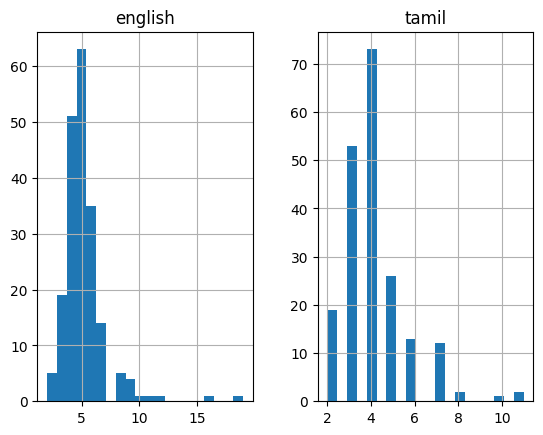

In [216]:
# let’s visualise the length of the sentences.
import pandas as pd
import matplotlib.pyplot as plt

eng_len = []
fren_len = []

# populate the lists with sentence lengths
for i in input_sentences:
      eng_len.append(len(i.split()))  

for i in output_sentences:
      fren_len.append(len(i.split()))

length_df = pd.DataFrame({'english':eng_len, 'tamil':fren_len})

length_df.hist(bins = 20)
plt.show()

The histogram above shows maximum length of the French sentences is 12 and that of the English sentence is 6.

For tokenization, the Tokenizer class from the keras.preprocessing.text library can be used. The tokenizer class performs two tasks:

It divides a sentence into the corresponding list of word

Then it converts the words to integers

Also the word_index attribute of the Tokenizer class returns a word-to-index dictionary where words are the keys and the corresponding integers are the values.

In [217]:
from keras.preprocessing.text import Tokenizer
#tokenize the input sentences(input language) 
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
print(input_integer_seq)


word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

#with open('input_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(input_tokenizer, handle, protocol=4)

[[3, 130], [131, 132], [57, 35], [36, 7, 4], [36, 133], [6, 78], [134, 1, 13], [36, 7, 6], [15, 1, 58], [16, 79, 135], [6, 136, 12], [6, 137, 12], [6, 7, 44], [6, 7, 138], [59, 45, 23], [46, 19, 139], [29, 8, 140], [141, 16, 1, 30], [3, 142, 143, 80], [57, 29, 1, 16], [24, 31, 1, 8], [47, 16, 1, 13], [60, 1, 25], [81, 5, 82], [17, 10, 29, 13], [37, 144, 1, 13], [4, 61, 1, 62], [4, 83, 63], [4, 145, 1, 62], [64, 7, 21, 146], [3, 26, 1, 58], [18, 147, 1, 62], [148, 21, 149], [38, 48, 4, 150], [20, 49, 23, 84], [17, 10, 85, 39], [4, 7, 86, 65], [3, 32, 1, 15, 66], [3, 33, 27, 80], [3, 87, 9, 151], [3, 35, 1, 88], [81, 89, 152], [153, 45, 22, 154], [35, 90, 2, 13], [155, 156, 8], [91, 2, 5, 92], [4, 157, 158, 159], [4, 28, 93, 160], [3, 33, 64, 1, 161], [3, 33, 38, 1, 14], [18, 44, 2, 94], [46, 1, 5, 95], [6, 61, 1, 162], [6, 163, 1, 15], [14, 3, 32, 1, 164], [4, 7, 96, 1, 17], [3, 97, 1, 35, 98], [3, 32, 1, 99, 31], [3, 67, 12, 1, 17], [18, 165, 2, 50], [79, 3, 100, 1, 8], [6, 101, 16, 1,

In [218]:
#tokenize the output sentences(Output language)
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
print(output_input_integer_seq)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)


[[1, 100], [39, 101], [1, 102], [3, 40], [103, 104], [2, 105], [8, 106], [2, 40], [16, 107], [108, 109], [2, 27, 110], [2, 27, 111], [2, 112], [113, 114, 115], [116, 41, 117], [118, 42], [119, 120], [28, 121], [1, 12, 122], [29, 1, 43], [44, 123, 17], [8, 124], [125, 126], [18, 127, 128], [129, 45, 46], [8, 130, 131], [3, 30, 47], [3, 132, 31], [3, 30, 133, 134], [135, 136, 32, 137], [1, 138, 19], [48, 30, 139], [140, 141], [3, 20, 142], [21, 143, 49, 144], [50, 51, 52, 145], [3, 53, 146], [1, 54, 55, 10], [11, 147, 148], [1, 5, 149, 150], [1, 151, 152, 153], [154, 56, 155], [156, 57, 157, 158], [11, 58, 159], [22, 160, 161, 162, 163], [164, 165], [3, 166, 167, 31], [168, 59, 169], [32, 170, 171, 172, 60, 11, 13], [20, 173, 60, 33, 13], [1, 5, 174, 175], [176, 177, 178, 179], [2, 180, 181], [2, 61, 182], [1, 183, 184], [3, 185, 186], [1, 187, 62, 188], [1, 63, 189, 10], [1, 190, 191, 192], [8, 34, 193, 17], [1, 23, 194], [2, 64, 65, 66], [2, 67, 68, 195], [2, 11, 196, 197], [198, 199, 

In [219]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[180]:", encoder_input_sequences[180])

encoder_input_sequences.shape: (201, 19)
encoder_input_sequences[180]: [  0   0   0   0   0   0   0   0   0   0   0   0   4 326   5 327  53 328
 329]


encoder_input_sequences.shape: (20000, 6)
encoder_input_sequences[180]: [  0   0   0   0 464  59]
Since there are 20,000 sentences in the input and each input sentence is of length 6, the shape of the input is now (20000, 6).

You may recall that the original sentence at index 180 is join us. The tokenizer divided the sentence into two words join and us, converted them to integers, and then applied pre-padding by adding four zeros at the start of the corresponding integer sequence for the sentence at index 180 of the input list.

To verify that the integer values for join and us are 464 and 59 respectively, you can pass the words to the word2index_inputs dictionary, as shown below:

In the same way, the decoder outputs and the decoder inputs are padded.

In [221]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[180]:", decoder_input_sequences[180])

decoder_input_sequences.shape: (201, 11)
decoder_input_sequences[180]: [  3 475 476 477 478   0   0   0   0   0   0]


decoder_input_sequences.shape: (20000, 12)
decoder_input_sequences[180]: [   2 2028   20  228    0    0    0    0    0    0    0    0]
The sentence at index 180 of the decoder input is Joignez-vous à nous. If you print the corresponding integers from the word2idx_outputs dictionary, you should see 2, 2028, 20, and 228 printed on the console.

In [222]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)

decoder_output_sequences.shape: (201, 11)


Word Embeddings
We already converted our words into integers. So what's the difference between integer representation and word embeddings?

There are two main differences between single integer representation and word embeddings. With integer reprensentation, a word is represented only with a single integer. With vector representation a word is represented by a vector of 50, 100, 200, or whatever dimensions you like. Hence, word embeddings capture a lot more information about words. Secondly, the single-integer representation doesn't capture the relationships between different words. On the contrary, word embeddings retain relationships between the words. You can either use custom word embeddings or you can use pretrained word embeddings.

For English sentences, i.e. the inputs, we will use the GloVe word embeddings. For the translated French sentences in the output, we will use custom word embeddings.

Let's create word embeddings for the inputs first. To do so, we need to load the GloVe word vectors into memory. We will then create a dictionary where words are the keys and the corresponding vectors are values,

# EXCERCISE 3 Extractive text Summarisation

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv(r"C:\Users\Keerthana\Desktop\Model\NLP\Trail\Dataset\Articles.csv")
data = df["content"].values

print("Number of Articles : ", len(data))

Number of Articles :  1303


In [25]:
import re
from nltk.tokenize import sent_tokenize

def pre_processing(text):
    
    # text to sentence
    tokenized = sent_tokenize(text)   
    # Remove Punctuation
    # Lower Case 
    # Strip White Spaces
    pattern   = re.compile(r'[^a-zA-Z0-9\s]')
    tokenized = [pattern.sub('', sent).strip().lower() for sent in tokenized]
    #print(tokenized)
    return tokenized

corpus = []
for doc in data:
    corpus.extend(pre_processing(doc))
    #print(doc)
    
print("Number of Sentences in Corpus : ", len(corpus))

Number of Sentences in Corpus :  31603


In [18]:
input_text = """
Millions go missing at China bank. 

Two senior officials at one of China's top commercial banks have reportedly disappeared after funds
worth up to $120m (£64m) went missing. The pair both worked at Bank of China in the northern city
of Harbin, the South China Morning Post reported.

The latest scandal at Bank of China will do nothing to reassure foreign investors that China's
big four banks are ready for international listings. Government policy sees the bank listings as vital
economic reforms. Bank of China is one of two frontrunners in the race to list overseas. The other is
China Construction Bank. Both are expected to list abroad during 2005. They shared a $45bn state
bailout in 2003, to help clean up their balance sheets in preparation for a foreign stock market debut.

However, a report in the China-published Economic Observer said on Monday that the two banks may
have scrapped plans to list in New York because of the cost of meeting regulatory requirements
imposed since the Enron scandal. Bank of China is the country's biggest foreign exchange dealer,
while China Construction Bank is the largest deposit holder.

China's banking sector is burdened with at least $190bn of bad debt according to official data,
though most observers believe the true figure is far higher. Officially, one in five loans is not
being repaid. Attempts to strengthen internal controls and tighten lending policies have uncovered
a succession of scandals involving embezzlement by bank officials and loans-for-favours. The most
high-profile case involved the ex-president of Bank of China, Wang Xuebing, jailed for 12 years in
2003. Although he committed the offences whilst running Bank of China in New York, Mr. Wang was
head of China Construction Bank when the scandal broke. Earlier this month, a China Construction
Bank branch manager was jailed for life in a separate case.

China's banks used to act as cash offices for state enterprises and did not require checks on credit
worthiness. The introduction of market reforms has been accompanied by attempts to modernize the
banking sector, but links between banks and local government remain strong. Last year, China's
premier, Wen Jiabao, targeted bank lending practices in a series of speeches, and regulators ordered
all big loans to be scrutinized, in an attempt to cool down irresponsible lending.

China's leaders see reforming the top four banks as vital to distribute capital to profitable
companies and protect the health of China's economic boom. But two problems persist. First,
inefficient state enterprises continue to receive protection from bankruptcy because they employ
large numbers of people. Second, many questionable loans come not from the big four, but from
smaller banks.

Another high-profile financial firm, China Life, is facing shareholder lawsuits and a probe by the
US Securities and Exchange Commission following its 2004 New York listing over its failure to
disclose accounting irregularities at its parent company.
"""

input_text = input_text.replace("\n", " ")
sentences = sent_tokenize(input_text)
input_tok = pre_processing(input_text)
print(input_tok)

['millions go missing at china bank', 'two senior officials at one of chinas top commercial banks have reportedly disappeared after funds worth up to 120m 64m went missing', 'the pair both worked at bank of china in the northern city of harbin the south china morning post reported', 'the latest scandal at bank of china will do nothing to reassure foreign investors that chinas big four banks are ready for international listings', 'government policy sees the bank listings as vital economic reforms', 'bank of china is one of two frontrunners in the race to list overseas', 'the other is china construction bank', 'both are expected to list abroad during 2005', 'they shared a 45bn state bailout in 2003 to help clean up their balance sheets in preparation for a foreign stock market debut', 'however a report in the chinapublished economic observer said on monday that the two banks may have scrapped plans to list in new york because of the cost of meeting regulatory requirements imposed since t

In [232]:
from rouge_score import rouge_scorer

expected = """
The other is China Construction Bank. The latest scandal at Bank of China will do nothing to reassure
foreign investors that China's big four banks are ready for international listings. 
Bank of China is the country's biggest foreign exchange dealer, while China Construction Bank is the
largest deposit holder. Bank of China is one of two frontrunners in the race to list overseas. 
Although he committed the offences whilst running Bank of China in New York, Mr. Wang was head of
China Construction Bank when the scandal broke. Earlier this month, a China Construction Bank branch
manager was jailed for life in a separate case. The pair both worked at Bank of China in the
northern city of Harbin, the South China Morning Post reported. The most high-profile case involved
the ex-president of Bank of China, Wang Xuebing, jailed for 12 years in 2003. 
Two senior officials at one of China's top commercial banks have reportedly disappeared after funds
worth up to $120m (£64m) went missing. China’s banks used to act as cash offices for state
enterprises and did not require checks on credit worthiness.
"""

expected = expected.replace("\n", " ").strip()

def rouge_metrics(summary):
    
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    scores = scorer.score(summary, expected)
    
    print("Rouge Score : ", scores, end="\n\n")

In [235]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

def summarize(input_vec):
    # Cosine Similarity
    similarity_matrix = cosine_similarity(input_vec, input_vec)

    # Matrix to Graph
    G = nx.from_numpy_array(similarity_matrix)

    # PageRank Algorithm
    pagerank_scores = nx.pagerank(G)

    # Sort sentences based on PageRank Scores
    sorted_sentences = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)

    # Select top 10 
    top_k = 10
    summary = [sentences[i] for i in sorted_sentences[:top_k]]

    rouge_metrics(" ".join(summary))
    print(" ".join(summary))

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

bag_of_words = CountVectorizer()

corpus_bow = bag_of_words.fit_transform(corpus)
input_bow  = bag_of_words.transform(input_tok)
print(type(input_bow))
print(input_bow.shape)
print(input_bow)
corpus_bow.shape

<class 'scipy.sparse._csr.csr_matrix'>
(25, 35825)
  (0, 3429)	1
  (0, 3910)	1
  (0, 6626)	1
  (0, 14086)	1
  (0, 20724)	1
  (0, 20889)	1
  (1, 2108)	1
  (1, 3429)	1
  (1, 3919)	1
  (1, 6627)	1
  (1, 7341)	1
  (1, 9877)	1
  (1, 13521)	1
  (1, 15039)	1
  (1, 20889)	1
  (1, 22552)	1
  (1, 22585)	1
  (1, 22731)	1
  (1, 26774)	1
  (1, 28615)	1
  (1, 32454)	1
  (1, 32537)	1
  (1, 33181)	1
  (1, 33816)	1
  (1, 34921)	1
  :	:
  (24, 7402)	1
  (24, 9910)	1
  (24, 11823)	1
  (24, 12160)	1
  (24, 12195)	1
  (24, 12693)	1
  (24, 12760)	1
  (24, 13059)	1
  (24, 15420)	1
  (24, 17105)	1
  (24, 17128)	1
  (24, 17199)	3
  (24, 18607)	1
  (24, 18912)	1
  (24, 19072)	1
  (24, 21892)	1
  (24, 23137)	1
  (24, 23493)	1
  (24, 25116)	1
  (24, 28442)	1
  (24, 28858)	1
  (24, 32046)	1
  (24, 32454)	1
  (24, 33900)	1
  (24, 35629)	1


(31603, 35825)

In [237]:
summarize(input_bow)

Rouge Score :  {'rouge1': Score(precision=0.7905759162303665, recall=0.6894977168949772, fmeasure=0.7365853658536586)}

Bank of China is one of two frontrunners in the race to list overseas. The pair both worked at Bank of China in the northern city of Harbin, the South China Morning Post reported. The most high-profile case involved the ex-president of Bank of China, Wang Xuebing, jailed for 12 years in 2003. Although he committed the offences whilst running Bank of China in New York, Mr. Wang was head of China Construction Bank when the scandal broke. Bank of China is the country's biggest foreign exchange dealer, while China Construction Bank is the largest deposit holder. However, a report in the China-published Economic Observer said on Monday that the two banks may have scrapped plans to list in New York because of the cost of meeting regulatory requirements imposed since the Enron scandal. The latest scandal at Bank of China will do nothing to reassure foreign investors that Chi

In [238]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer()

corpus_idf = tf_idf.fit_transform(corpus)
input_idf = tf_idf.transform(input_tok)

In [239]:
summarize(input_idf)

Rouge Score :  {'rouge1': Score(precision=0.8481675392670157, recall=0.9, fmeasure=0.8733153638814016)}

Bank of China is one of two frontrunners in the race to list overseas. The other is China Construction Bank. The latest scandal at Bank of China will do nothing to reassure foreign investors that China's big four banks are ready for international listings. Bank of China is the country's biggest foreign exchange dealer, while China Construction Bank is the largest deposit holder. Although he committed the offences whilst running Bank of China in New York, Mr. Wang was head of China Construction Bank when the scandal broke.  Millions go missing at China bank. The pair both worked at Bank of China in the northern city of Harbin, the South China Morning Post reported. The most high-profile case involved the ex-president of Bank of China, Wang Xuebing, jailed for 12 years in 2003. Earlier this month, a China Construction Bank branch manager was jailed for life in a separate case. China's

In [240]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

g_model = Word2Vec(sentences=[word_tokenize(sent) for sent in corpus], vector_size=200, window=5, workers=5, epochs=500)

In [241]:
def get_embeddings(sent_l):
    vec = np.array([g_model.wv[word] if word in g_model.wv else np.zeros((200)) for word in sent_l])
    vec = vec.sum(axis=0)
    return vec

input_cbow = np.array([get_embeddings(sent) for sent in [word_tokenize(sent) for sent in input_tok]])

In [242]:
summarize(input_cbow)

Rouge Score :  {'rouge1': Score(precision=0.6649214659685864, recall=0.5746606334841629, fmeasure=0.616504854368932)}

Bank of China is one of two frontrunners in the race to list overseas. The latest scandal at Bank of China will do nothing to reassure foreign investors that China's big four banks are ready for international listings. Bank of China is the country's biggest foreign exchange dealer, while China Construction Bank is the largest deposit holder. The other is China Construction Bank. China's leaders see reforming the top four banks as vital to distribute capital to profitable companies and protect the health of China's economic boom. The most high-profile case involved the ex-president of Bank of China, Wang Xuebing, jailed for 12 years in 2003. However, a report in the China-published Economic Observer said on Monday that the two banks may have scrapped plans to list in New York because of the cost of meeting regulatory requirements imposed since the Enron scandal. The int

In [243]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

g_model = Word2Vec(sentences=[word_tokenize(sent) for sent in corpus], vector_size=200, window=5, workers=5, epochs=500, sg=1)

In [244]:
def get_embeddings(sent_l):
    vec = np.array([g_model.wv[word] if word in g_model.wv else np.zeros((200)) for word in sent_l])
    vec = vec.sum(axis=0)
    return vec

input_sg = np.array([get_embeddings(sent) for sent in [word_tokenize(sent) for sent in input_tok]])

In [245]:
summarize(input_sg)

Rouge Score :  {'rouge1': Score(precision=0.743455497382199, recall=0.5089605734767025, fmeasure=0.6042553191489362)}

The latest scandal at Bank of China will do nothing to reassure foreign investors that China's big four banks are ready for international listings. Although he committed the offences whilst running Bank of China in New York, Mr. Wang was head of China Construction Bank when the scandal broke. Last year, China's premier, Wen Jiabao, targeted bank lending practices in a series of speeches, and regulators ordered all big loans to be scrutinized, in an attempt to cool down irresponsible lending. However, a report in the China-published Economic Observer said on Monday that the two banks may have scrapped plans to list in New York because of the cost of meeting regulatory requirements imposed since the Enron scandal. Another high-profile financial firm, China Life, is facing shareholder lawsuits and a probe by the US Securities and Exchange Commission following its 2004 New

In [246]:
import gensim.downloader as api

model = api.load("glove-wiki-gigaword-200")

def get_embeddings(sent_l):
    vec = np.array([model[word] if word in model else np.zeros((200)) for word in sent_l])
    vec = vec.sum(axis=0)
    return vec

input_wv = np.array([get_embeddings(sent) for sent in [word_tokenize(sent) for sent in input_tok]])

[====----------------------------------------------] 9.3% 23.4/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========----------------------------------------] 21.9% 55.2/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 34.1% 85.9/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 46.2% 116.6/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================----------------------] 58.0% 146.2/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================================---------------] 70.4% 177.5/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================================---------] 83.1% 209.5/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.9% 241.8/252.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [247]:
summarize(input_wv)

Rouge Score :  {'rouge1': Score(precision=0.6544502617801047, recall=0.45787545787545786, fmeasure=0.5387931034482758)}

However, a report in the China-published Economic Observer said on Monday that the two banks may have scrapped plans to list in New York because of the cost of meeting regulatory requirements imposed since the Enron scandal. The latest scandal at Bank of China will do nothing to reassure foreign investors that China's big four banks are ready for international listings. The introduction of market reforms has been accompanied by attempts to modernize the banking sector, but links between banks and local government remain strong. Bank of China is one of two frontrunners in the race to list overseas. China's banking sector is burdened with at least $190bn of bad debt according to official data, though most observers believe the true figure is far higher. Last year, China's premier, Wen Jiabao, targeted bank lending practices in a series of speeches, and regulators order

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(r"GloVe/glove.6B.50d.word2vec", binary=False)

def get_embeddings(sent_l):
    vec = np.array([model[word] if word in model else np.zeros((50)) for word in sent_l])
    vec = vec.sum(axis=0)
    return vec

input_glove = np.array([get_embeddings(sent) for sent in [word_tokenize(sent) for sent in input_tok]])

In [ ]:
summarize(input_glove)

In [ ]:
from gensim.models import FastText
from nltk.tokenize import word_tokenize

f_model = FastText(sentences=[word_tokenize(sent) for sent in corpus], vector_size=200, window=5, workers=5, epochs=500)

In [ ]:
def get_embeddings(sent_l):
    vec = np.array([f_model.wv[word] if word in f_model.wv else np.zeros((200)) for word in sent_l])
    vec = vec.sum(axis=0)
    return vec

input_ft = np.array([get_embeddings(sent) for sent in [word_tokenize(sent) for sent in input_tok]])

In [ ]:
summarize(input_ft)

### EXERCISE 1 - SPELL CHECK USING TRIE DS

In [31]:
! pip install levenshtein

     ---------------------------------------- 98.6/98.6 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 5.6 MB/s eta 0:00:00


In [32]:
import nltk
from nltk.collections import Trie
from nltk.corpus import words
import Levenshtein

In [33]:
words.words()

['A',
 'a',
 'aa',
 'aal',
 'aalii',
 'aam',
 'Aani',
 'aardvark',
 'aardwolf',
 'Aaron',
 'Aaronic',
 'Aaronical',
 'Aaronite',
 'Aaronitic',
 'Aaru',
 'Ab',
 'aba',
 'Ababdeh',
 'Ababua',
 'abac',
 'abaca',
 'abacate',
 'abacay',
 'abacinate',
 'abacination',
 'abaciscus',
 'abacist',
 'aback',
 'abactinal',
 'abactinally',
 'abaction',
 'abactor',
 'abaculus',
 'abacus',
 'Abadite',
 'abaff',
 'abaft',
 'abaisance',
 'abaiser',
 'abaissed',
 'abalienate',
 'abalienation',
 'abalone',
 'Abama',
 'abampere',
 'abandon',
 'abandonable',
 'abandoned',
 'abandonedly',
 'abandonee',
 'abandoner',
 'abandonment',
 'Abanic',
 'Abantes',
 'abaptiston',
 'Abarambo',
 'Abaris',
 'abarthrosis',
 'abarticular',
 'abarticulation',
 'abas',
 'abase',
 'abased',
 'abasedly',
 'abasedness',
 'abasement',
 'abaser',
 'Abasgi',
 'abash',
 'abashed',
 'abashedly',
 'abashedness',
 'abashless',
 'abashlessly',
 'abashment',
 'abasia',
 'abasic',
 'abask',
 'Abassin',
 'abastardize',
 'abatable',
 'abate

In [34]:
def build_trie():
    trie = Trie()
    word_list = words.words()
    for word in word_list:
        trie.insert(word.lower())  
    return trie

In [35]:
t = build_trie()

In [36]:
def get_similar_words(trie, input_word, num_similar=5):
    similar_words = []
    for word in trie:
        distance = Levenshtein.distance(input_word, word)
        similar_words.append((word, distance))

    similar_words.sort(key=lambda x: x[1])  
    return [word for word, _ in similar_words[:num_similar]]

misspelled_word = "appl"
similar_words = get_similar_words(t, misspelled_word, num_similar=6)

print(f"Misspelled word: {misspelled_word}")
print(f"Similar words: {similar_words}")

Misspelled word: appl
Similar words: ['a', 'l', 'p', 'b', 'c', 'd']


In [37]:
from nltk.corpus import words
word_list = words.words()
# prints 236736
print(len(word_list))

236736


In [38]:
trie = {}

for word in word_list:
    cur = trie
    for l in word:
        cur  = cur.setdefault(l, {})
        cur['word'] = True # defined if this node indicates a complete word
        
def findWords(word, trie = trie, cur = '', word_list = []):
    for i, letter in enumerate(word):
        if letter in trie:
            if 'word' in trie[letter]:
                word_list.append(cur + letter)
            findWords(word, trie[letter], cur+letter, word_list )    
            

    return word_list

words_longer = findWords("weathar")

In [39]:
longer_list = []

for word in words_longer:
    if len(word) > 1:
        longer_list.append(word)
print(longer_list)

['we', 'wee', 'weew', 'weet', 'wea', 'weat', 'weath', 'weathe', 'weather', 'weatherw', 'weatherwa', 'weatherwar', 'weatherwa', 'weatherwar', 'weathere', 'weatherer', 'weatherh', 'weatherhe', 'weatherhea', 'weatherhea', 'wear', 'weare', 'wearer', 'weara', 'weara', 'wet', 'weta', 'wett', 'wette', 'wetter', 'wetta', 'wetta', 'weth', 'wethe', 'wether', 'wethert', 'wetherte', 'wetherh', 'weta', 'weh', 'wehr', 'wea', 'weat', 'weath', 'weathe', 'weather', 'weatherw', 'weatherwa', 'weatherwar', 'weatherwa', 'weatherwar', 'weathere', 'weatherer', 'weatherh', 'weatherhe', 'weatherhea', 'weatherhea', 'wear', 'weare', 'wearer', 'weara', 'weara', 'wer', 'were', 'werew', 'weret', 'wereh', 'wert', 'wa', 'waw', 'wawa', 'wawah', 'wawa', 'wawah', 'wae', 'waer', 'waa', 'waar', 'wat', 'wate', 'water', 'waterw', 'waterwe', 'waterwee', 'waterwa', 'waterwar', 'waterwa', 'waterwar', 'watere', 'waterer', 'watera', 'watert', 'waterh', 'waterhe', 'waterhea', 'waterhea', 'watera', 'wata', 'watt', 'watta', 'watta'

In [40]:
similar_words=[]
for words in longer_list:
    distance = Levenshtein.distance("weathar", words)
    similar_words.append((words, distance))
similar_words = sorted(similar_words, key=lambda x: x[1])
print(similar_words)

[('weather', 1), ('weather', 1), ('weath', 2), ('weathe', 2), ('weatherw', 2), ('weathere', 2), ('weatherh', 2), ('wether', 2), ('weath', 2), ('weathe', 2), ('weatherw', 2), ('weathere', 2), ('weatherh', 2), ('wheatear', 2), ('wheatear', 2), ('wheatear', 2), ('wheatear', 2), ('wreather', 2), ('wreatha', 2), ('wreatha', 2), ('wreather', 2), ('wreatha', 2), ('wreatha', 2), ('aweather', 2), ('aweather', 2), ('athar', 2), ('athar', 2), ('teather', 2), ('teather', 2), ('heather', 2), ('heather', 2), ('aweather', 2), ('aweather', 2), ('athar', 2), ('athar', 2), ('weat', 3), ('weatherwa', 3), ('weatherwar', 3), ('weatherwa', 3), ('weatherwar', 3), ('weatherer', 3), ('weatherhe', 3), ('wear', 3), ('wearer', 3), ('weara', 3), ('weara', 3), ('weta', 3), ('wetter', 3), ('wetta', 3), ('wetta', 3), ('weth', 3), ('wethe', 3), ('wethert', 3), ('wetherh', 3), ('weta', 3), ('wehr', 3), ('weat', 3), ('weatherwa', 3), ('weatherwar', 3), ('weatherwa', 3), ('weatherwar', 3), ('weatherer', 3), ('weatherhe',

## Constituency Parsing - Syntatic parsing






https://applied-language-technology.mooc.fi/html/notebooks/part_ii/03_basic_nlp.html#syntactic-parsing

https://www.nltk.org/howto/tree.html


https://kgptalkie.com

https://spacy.io/api/dependencyparser

https://spacy.io/usage/linguistic-features
https://kgptalkie.com


https://github.com/wjbmattingly/fewshot-text/blob/main/youtube-crosslingual.ipynb


https://github.com/Applied-Language-Technology/notebooks



https://github.com/JaewonSon37/PBL_Natural_Language_Processing2/blob/main/Dependency%20Parsing%20on%20Sentences%20Generated%20by%20N-gram%20Language%20Model.ipynb

## Dependency parsing - Deteministic/Transition based

Syntactic Parsing or Dependency Parsing with Spacy | NLP | Text Processing | Machine Learning
subject - Object Combined

In [152]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [154]:
from spacy import displacy
doc = nlp('Elon is the CEO of Tesla')
displacy.render(doc,style="dep")

In [156]:
# Assign an example sentence to the variable 'text'
text = "The Federal Bureau of Investigation has been ordered to track down as many as 3,000 Iraqis in this country whose visas have expired, the Justice Department said yesterday."

# Call the variable to examine the output
text

'The Federal Bureau of Investigation has been ordered to track down as many as 3,000 Iraqis in this country whose visas have expired, the Justice Department said yesterday.'

In [157]:
# Feed the string object under 'text' to the Language object under 'nlp'
# Store the result under the variable 'doc'
doc = nlp(text)

In [158]:
# Loop over items in the Doc object, using the variable 'token' to refer to items in the list
for token in doc:
    
    # Print the token and its dependency tag
    print(token, token.dep_)

The det
Federal compound
Bureau nsubjpass
of prep
Investigation pobj
has aux
been auxpass
ordered ccomp
to aux
track xcomp
down prt
as advmod
many amod
as quantmod
3,000 nummod
Iraqis dobj
in prep
this det
country pobj
whose poss
visas nsubj
have aux
expired relcl
, punct
the det
Justice compound
Department nsubj
said ROOT
yesterday npadvmod
. punct


In [159]:
# Loop over items in the Doc object, using the variable 'token' to refer to items in the list
for token in doc:
    
    # Print the index of current token, the token itself, the dependency, the head and its index
    print(token.i, token, token.dep_, token.head.i, token.head)

0 The det 2 Bureau
1 Federal compound 2 Bureau
2 Bureau nsubjpass 7 ordered
3 of prep 2 Bureau
4 Investigation pobj 3 of
5 has aux 7 ordered
6 been auxpass 7 ordered
7 ordered ccomp 27 said
8 to aux 9 track
9 track xcomp 7 ordered
10 down prt 9 track
11 as advmod 14 3,000
12 many amod 14 3,000
13 as quantmod 14 3,000
14 3,000 nummod 15 Iraqis
15 Iraqis dobj 9 track
16 in prep 15 Iraqis
17 this det 18 country
18 country pobj 16 in
19 whose poss 20 visas
20 visas nsubj 22 expired
21 have aux 22 expired
22 expired relcl 18 country
23 , punct 27 said
24 the det 26 Department
25 Justice compound 26 Department
26 Department nsubj 27 said
27 said ROOT 27 said
28 yesterday npadvmod 27 said
29 . punct 27 said


In [160]:
from spacy import displacy

In [161]:
displacy.render(doc, style='dep', options={'compact': True})

In [162]:
spacy.explain('pobj')

'object of preposition'

In [163]:
print(doc[0], doc[0].dep, doc[0].dep_)

The 415 det


https://applied-language-technology.mooc.fi/html/notebooks/part_ii/03_basic_nlp.html#syntactic-parsing

In [180]:
text = "Apple is looking at buying U.K. startup fro $1 billion"
doc = nlp(text)

In [181]:
pip install beautifultable

In [182]:
from beautifultable import BeautifulTable

In [183]:
table = BeautifulTable()

In [184]:
table.columns.header = ['text','POS','TAG','Explain_tag','Dep','Shape','is_alpha','is_stop']
for token in doc:
    table.rows.append([token.text,token.pos_,token.tag_,spacy.explain(token.tag_),token.dep_,token.shape_,token.is_alpha,token.is_stop])

In [185]:
print(table)

+------+---------+-----+--------------------------+------+-------+------+------+
| text |   POS   | TAG |       Explain_tag        | Dep  | Shape | is_a | is_s |
|      |         |     |                          |      |       | lpha | top  |
+------+---------+-----+--------------------------+------+-------+------+------+
| Appl |  PROPN  | NNP |  noun, proper singular   | nsub | Xxxxx |  1   |  0   |
|  e   |         |     |                          |  j   |       |      |      |
+------+---------+-----+--------------------------+------+-------+------+------+
|  is  |   AUX   | VBZ | verb, 3rd person singula | aux  |  xx   |  1   |  1   |
|      |         |     |        r present         |      |       |      |      |
+------+---------+-----+--------------------------+------+-------+------+------+
| look |  VERB   | VBG | verb, gerund or present  | ROOT | xxxx  |  1   |  0   |
| ing  |         |     |        participle        |      |       |      |      |
+------+---------+-----+----

In [186]:
from spacy import displacy

In [193]:
options = {"compact":True,"distance":100,"bg":"#00FFFF"}
displacy.render(doc,style= 'dep',options= options)

In [189]:
displacy.serve(doc,style= 'dep')


Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


https://www.youtube.com/watch?v=n7lJcPBno-c
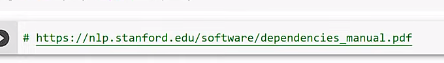
https://spacy.io/models/en
https://www.nltk.org/_modules/nltk/parse/transitionparser.html

https://medium.com/data-science-in-your-pocket/dependency-parsing-associated-algorithms-in-nlp-96d65dd95d3e

In [11]:
import random
from nltk.util import ngrams
from nltk import word_tokenize
from nltk import ConditionalFreqDist
from nltk.probability import ConditionalProbDist, MLEProbDist
import nltk

# Download necessary NLTK resources
nltk.download('punkt')

# Sample English comments
sample_comments = [
    "This is a great tutorial!",
    "I found this article very helpful.",
    "Thanks for sharing this information.",
    "This website provides useful resources."
]

# Tokenize sample comments and create bigrams
sentences = []
for comment in sample_comments:
    tokens = word_tokenize(comment)
    bigram = ngrams(tokens, 2, pad_left=True, pad_right=True, left_pad_symbol="", right_pad_symbol="")
    sentences += [t for t in bigram]

print(sentences[:10])

# Create Conditional Frequency Distribution
cfd = ConditionalFreqDist(sentences)
print(cfd[""].most_common(5))

# Function to find most common words following a given token
def most_common(token, n, pos=None):
    if pos is None:
        return cfd[word_tokenize(token)[0]].most_common(n)
    else:
        return cfd[" ".join([token, pos])].most_common(n)

print(most_common("This", 10))

# Create Conditional Probability Distribution based on word frequencies
cpd = ConditionalProbDist(cfd, MLEProbDist)
print(cpd[word_tokenize(".")[0]].prob(""))

# Function to calculate the probability of a word w following a context c in bigram
def bigram_prob(context, word):
    context_token = word_tokenize(context)[0]
    word_token = word_tokenize(word)[0]
    return cpd[context_token].prob(word_token)

print(bigram_prob("This", "is"))
print(bigram_prob("is", "a"))

# Generate a sentence based on the learned probabilities
def generate_sentence(seed=None):
    if seed is not None:
        random.seed(seed)
    current_context = ""
    sentence = []

    while True:
        if current_context not in cpd:
            break

        generated_word = cpd[current_context].generate()

        if generated_word == "":
            break

        sentence.append(" " + generated_word)
        current_context = generated_word

    return "".join(sentence)

# Print generated sentences
for i in range(1, 11):
    print(generate_sentence(i))


[('', 'This'), ('This', 'is'), ('is', 'a'), ('a', 'great'), ('great', 'tutorial'), ('tutorial', '!'), ('!', ''), ('', 'I'), ('I', 'found'), ('found', 'this')]
[('This', 2), ('I', 1), ('Thanks', 1)]
[('is', 1), ('website', 1)]
1.0
0.5
1.0
 This website provides useful resources .
 Thanks for sharing this information .
 This website provides useful resources .
 This is a great tutorial !
 I found this information .
 Thanks for sharing this article very helpful .
 This is a great tutorial !
 This website provides useful resources .
 This is a great tutorial !
 I found this article very helpful .


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Keerthana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])


Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability, toward]
insurance compound liability NOUN []
liability dobj shift VERB [insurance]
toward prep shift VERB [manufacturers]
manufacturers pobj toward ADP []


In [17]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Apple 0 5 ORG
U.K. 27 31 GPE
$1 billion 44 54 MONEY


In [18]:
import spacy
from spacy.symbols import nsubj, VERB

nlp = spacy.load("en_core_web_sm")
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

# Finding a verb with a subject from below — good
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)


{shift}


In [20]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1


['bright', 'red']
['on']
2
1


In [22]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])


Credit nmod 0 2 ['account', 'holders', 'submit']
and cc 0 0 ['Credit', 'account', 'holders', 'submit']
mortgage conj 0 0 ['Credit', 'account', 'holders', 'submit']
account compound 1 0 ['holders', 'submit']
holders nsubj 1 0 ['submit']


In [23]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")
# Since this is an interactive Jupyter environment, we can use displacy.render here
displacy.render(doc, style='dep')


In [3]:
import spacy
py_text = "spacy dependency parser in python"
py_nlp = spacy.load ("en_core_web_sm")
py_doc = py_nlp (py_text)
for token in py_doc:
            print (token.py_text, token.dep_,"token head is", token.head.py_text,
[child for child in token.children]

SyntaxError: unexpected EOF while parsing (3865548049.py, line 7)

In [2]:
import spacy
py_text = "spacy dependency parser in python."
py_nlp = spacy.load("en_core_web_sm")
py_doc = py_nlp( py_text)
from spacy import displacy
displacy.render(py_doc, style='dep')

In [4]:
import spacy
con_text = "spacy dependency parser in python."
py_nlp = spacy.load ("en_core_web_sm")
con_doc = py_nlp (con_text)
for token in con_doc:
    print(token.con_text, token.dep_,"Token head", token.head.con_text,
     [child for child in token.children]

SyntaxError: unexpected EOF while parsing (3059589089.py, line 7)